# The Lazy Artist: CNN Bias Detection and Intervention

## Table of Contents

1. [Task 0: The Biased Canvas](#task-0-the-biased-canvas) - Dataset Generation
2. [Task 1: The Cheater](#task-1-the-cheater) - Training the Biased Model
3. [Task 2: The Prober](#task-2-the-prober) - Neuron Visualization
4. [Task 3: The Interrogation](#task-3-the-interrogation) - Grad-CAM Implementation
5. [Task 4: The Intervention](#task-4-the-intervention) - Training Robust Models
6. [Task 5: The Invisible Cloak](#task-5-the-invisible-cloak) - Adversarial Attacks
7. [Task 6: The Decomposition](#task-6-the-decomposition) - Sparse Autoencoders

In [1]:
import numpy as np
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
import sys
from pathlib import Path

# Add project root to path for imports (notebook is in notebooks/ subdirectory)
project_root = Path('.').resolve().parent if Path('.').resolve().name == 'notebooks' else Path('.').resolve()
sys.path.insert(0, str(project_root))

# Import all utility functions from src/utils
from src.utils import (
    OUTPUT_ROOT,
    get_task_dir,
    get_task_figures_dir,
    get_task_checkpoints_dir,
    save_json,
    append_csv,
    save_fig,
    atomic_torch_save,
    load_checkpoint,
    save_checkpoint,
    save_best,
    save_task_outputs,
)

# Fix OUTPUT_ROOT to point to project root (not notebooks/)
from src.utils import task_utils
task_utils.OUTPUT_ROOT = project_root / 'outputs'
OUTPUT_ROOT = project_root / 'outputs'  # Update local reference

# Ensure output directory exists
OUTPUT_ROOT.mkdir(exist_ok=True)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

NUM_CLASSES = 10
P_BIAS = 0.95
BATCH_SIZE = 128
EPOCHS = 4
SEED = 0

# Save global config for reproducibility (saved to outputs/ root, not task-specific)
save_json({
    'device': device,
    'NUM_CLASSES': NUM_CLASSES,
    'P_BIAS': P_BIAS,
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'SEED': SEED,
}, OUTPUT_ROOT/'config.json')


Device: cpu


In [4]:
## Task 0: The Biased Canvas - Dataset Generation

In [5]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

In [6]:
COLOUR_MAP = np.array([
    [255,   0,   0],   # 0 red
    [  0, 255,   0],   # 1 green
    [  0,   0, 255],   # 2 blue
    [255, 255,   0],   # 3 yellow
    [255,   0, 255],   # 4 magenta
    [  0, 255, 255],   # 5 cyan
    [255, 128,   0],   # 6 orange
    [128,   0, 255],   # 7 purple
    [  0, 128, 255],   # 8 sky
    [128, 128, 128],   # 9 gray
], dtype=np.uint8)

In [7]:
def colorize_digit_textured(img_gray_uint8, color_rgb_uint8):
    """
    img_gray_uint8: torch uint8 [28,28] or numpy uint8 [28,28]
    color_rgb_uint8: length-3 uint8 RGB
    Returns uint8 [28,28,3] image with:
      - textured grayscale background
      - colored textured foreground stroke
    """
    if isinstance(img_gray_uint8, torch.Tensor):
        img = img_gray_uint8.detach().cpu().numpy()
    else:
        img = img_gray_uint8

    img = img.astype(np.float32) / 255.0  # [0,1]
    mask = img > 0                         # digit stroke

    # Background texture (grayscale noise)
    bg = np.random.normal(loc=0.30, scale=0.08, size=img.shape)
    bg = np.clip(bg, 0, 1)
    rgb = np.stack([bg, bg, bg], axis=-1)  # [H,W,3]

    # dding mild noise intensity
    fg_noise = np.random.normal(loc=0.0, scale=0.15, size=img.shape)
    texture = np.clip(img + fg_noise, 0, 1)

    color = (np.array(color_rgb_uint8, dtype=np.float32) / 255.0)

    for c in range(3):
        rgb[..., c][mask] = texture[mask] * color[c]

    return (rgb * 255).astype(np.uint8)

In [8]:
class BiasedMNIST(Dataset):
    """
    train_mode="easy": 95% digit->dominant color, 5% random other
    train_mode="hard": dominant color never appears (random non-dominant each sample)
    """
    def __init__(self, root="./data", base_train=True, mode="easy", rho=0.95, seed=0):
        super().__init__()
        assert mode in ["easy", "hard"]
        self.base = MNIST(root=root, train=base_train, download=True)

        self.mode = mode
        self.rho = rho
        self.seed = seed

        # Store raw tensors
        self.raw_imgs = self.base.data              # torch uint8 [N,28,28]
        self.targets  = self.base.targets.numpy()   # numpy int64 [N]

        # Precompute color_id for each sample deterministically
        self.color_ids = self._assign_colors()

        # Same normalization used in training (important for Task 3 too)
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # gives float [0,1], CHW
            transforms.Normalize((0.5,)*3, (0.5,)*3)  # -> roughly [-1,1]
        ])

    def _assign_colors(self):
        rng = np.random.RandomState(self.seed)
        N = len(self.targets)
        color_ids = np.zeros(N, dtype=np.int64)

        if self.mode == "easy":
            # 95% dominant, 5% non-dominant
            for i in range(N):
                d = int(self.targets[i])
                if rng.rand() < self.rho:
                    color_ids[i] = d
                else:
                    # choose any non-dominant
                    choices = [k for k in range(10) if k != d]
                    color_ids[i] = rng.choice(choices)
        else:
            # hard: dominant NEVER appears (random non-dominant each sample)
            for i in range(N):
                d = int(self.targets[i])
                choices = [k for k in range(10) if k != d]
                color_ids[i] = rng.choice(choices)

        return color_ids

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        raw = self.raw_imgs[idx]              # torch uint8 [28,28]
        label = int(self.targets[idx])
        color_id = int(self.color_ids[idx])

        colored_uint8 = colorize_digit_textured(raw, COLOUR_MAP[color_id])   # [28,28,3] uint8
        img = Image.fromarray(colored_uint8)
        img = self.transform(img)  # torch float [3,28,28] normalized

        return img, label, color_id, raw  # raw used for counterfactuals

In [9]:
full_easy = BiasedMNIST("./data", base_train=True, mode="easy", rho=P_BIAS, seed=SEED)
hard_test = BiasedMNIST("./data", base_train=False, mode="hard", rho=P_BIAS, seed=SEED+1)

In [10]:
def stratified_split(ds, val_frac=0.1, seed=0):
    rng = np.random.RandomState(seed)
    train_idx, val_idx = [], []
    targets = ds.targets
    for d in range(10):
        idx = np.where(targets == d)[0]
        rng.shuffle(idx)
        n_val = int(len(idx) * val_frac)
        val_idx.extend(idx[:n_val])
        train_idx.extend(idx[n_val:])
    return Subset(ds, train_idx), Subset(ds, val_idx)

In [11]:
# Restart-safe split: cache indices to disk so reruns are identical and resumable
# Cache in outputs/artifacts/ for reproducibility
artifacts_dir = OUTPUT_ROOT / "artifacts"
artifacts_dir.mkdir(parents=True, exist_ok=True)
split_path = artifacts_dir / "easy_split_indices.npz"

if split_path.exists():
    z = np.load(split_path)
    train_idx = z["train_idx"].astype(int).tolist()
    val_idx   = z["val_idx"].astype(int).tolist()
    easy_train = Subset(full_easy, train_idx)
    easy_val   = Subset(full_easy, val_idx)
    print(f"[split] Loaded {split_path} (train={len(train_idx)}, val={len(val_idx)})")
else:
    easy_train, easy_val = stratified_split(full_easy, val_frac=0.1, seed=SEED)
    np.savez_compressed(split_path,
                        train_idx=np.array(easy_train.indices, dtype=np.int64),
                        val_idx=np.array(easy_val.indices, dtype=np.int64))
    print(f"[split] Saved {split_path} (train={len(easy_train)}, val={len(easy_val)})")


[split] Loaded C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\artifacts\easy_split_indices.npz (train=54004, val=5996)


In [12]:
easy_train_loader = DataLoader(easy_train, batch_size=BATCH_SIZE, shuffle=True)
easy_val_loader   = DataLoader(easy_val,   batch_size=BATCH_SIZE, shuffle=False)
hard_test_loader  = DataLoader(hard_test,  batch_size=BATCH_SIZE, shuffle=False)

In [13]:
def audit_dataset(ds, max_items=None):
    counts = np.zeros((10,10), dtype=np.int64)
    n = len(ds) if max_items is None else min(len(ds), max_items)
    for i in range(n):
        _, d, c, _ = ds[i]
        counts[d, c] += 1
    # normalize rows
    row_sum = counts.sum(axis=1, keepdims=True)
    return counts / np.maximum(row_sum, 1)

In [14]:
train_bias = audit_dataset(full_easy)
test_bias  = audit_dataset(hard_test)

In [15]:
print("\nEASY (TRAIN) COLOR DISTRIBUTION: % dominant color per digit")
for d in range(10):
    print(f"Digit {d}: dominant color {d} -> {train_bias[d,d]*100:.2f}%")

print("\nHARD (TEST) COLOR DISTRIBUTION: % dominant color per digit (should be 0.00%)")
for d in range(10):
    print(f"Digit {d}: dominant color {d} -> {test_bias[d,d]*100:.2f}%")


EASY (TRAIN) COLOR DISTRIBUTION: % dominant color per digit
Digit 0: dominant color 0 -> 95.31%
Digit 1: dominant color 1 -> 94.91%
Digit 2: dominant color 2 -> 94.78%
Digit 3: dominant color 3 -> 95.12%
Digit 4: dominant color 4 -> 95.75%
Digit 5: dominant color 5 -> 95.46%
Digit 6: dominant color 6 -> 95.03%
Digit 7: dominant color 7 -> 94.84%
Digit 8: dominant color 8 -> 95.06%
Digit 9: dominant color 9 -> 94.76%

HARD (TEST) COLOR DISTRIBUTION: % dominant color per digit (should be 0.00%)
Digit 0: dominant color 0 -> 0.00%
Digit 1: dominant color 1 -> 0.00%
Digit 2: dominant color 2 -> 0.00%
Digit 3: dominant color 3 -> 0.00%
Digit 4: dominant color 4 -> 0.00%
Digit 5: dominant color 5 -> 0.00%
Digit 6: dominant color 6 -> 0.00%
Digit 7: dominant color 7 -> 0.00%
Digit 8: dominant color 8 -> 0.00%
Digit 9: dominant color 9 -> 0.00%


In [16]:
def show_samples(ds, title, samples_per_digit=4):
    plt.figure(figsize=(samples_per_digit*2.2, 10))
    for digit in range(10):
        count = 0
        for i in range(len(ds)):
            img, d, c, _ = ds[i]
            if int(d) == digit:
                plt.subplot(10, samples_per_digit, digit*samples_per_digit + count + 1)
                # denorm for display
                vis = (img.permute(1,2,0)*0.5 + 0.5).clamp(0,1).numpy()
                plt.imshow(vis)
                plt.title(f"d={d}, c={c}", fontsize=8)
                plt.axis("off")
                count += 1
                if count == samples_per_digit:
                    break
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

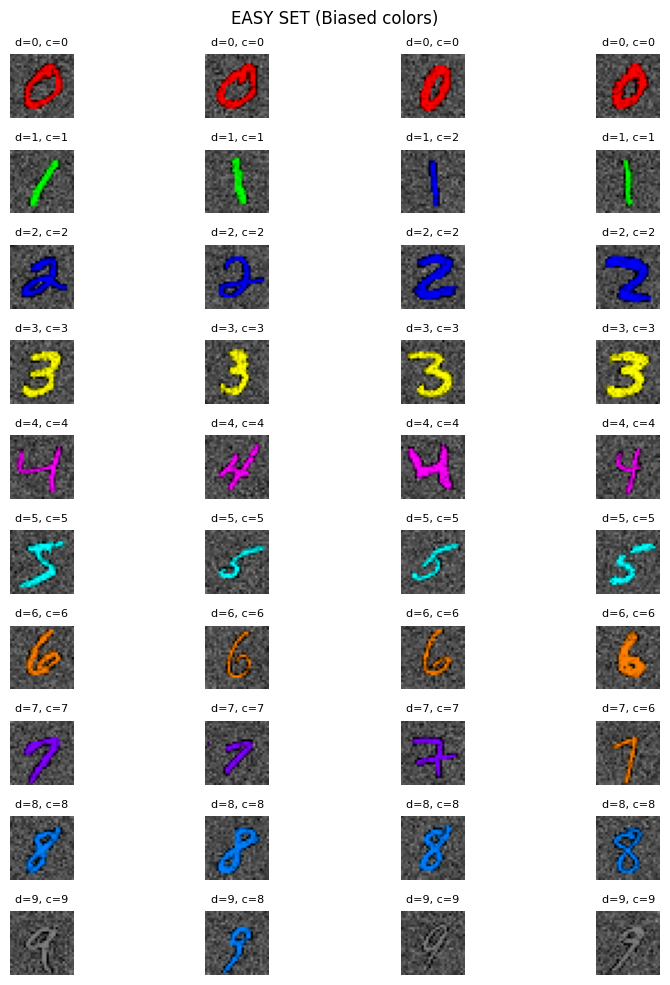

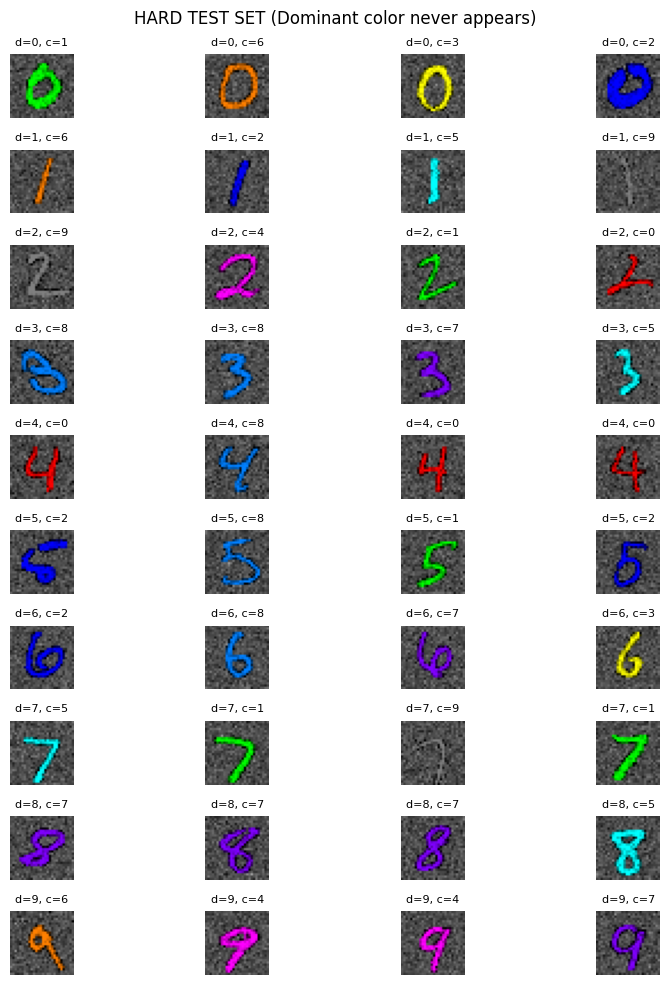

In [17]:
show_samples(full_easy, "EASY SET (Biased colors)")
show_samples(hard_test, "HARD TEST SET (Dominant color never appears)")

---

## Task 1: The Cheater - Training the Biased Model


In [18]:
class Simple3LayerCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)        # 28 -> 14

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)        # 14 -> 7

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu3 = nn.ReLU()              # final conv activation 

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.relu3(self.conv3(x))       # final conv block output
        x = self.gap(x).flatten(1)
        return self.fc(x)

In [19]:
model = Simple3LayerCNN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [20]:
def train_epoch(model, loader, opt):
    model.train()
    correct = total = 0
    for x, y, _, _ in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad(set_to_none=True)
        out = model(x)
        loss = F.cross_entropy(out, y)
        loss.backward()
        opt.step()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    return correct / total

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    correct = total = 0
    preds, targs = [], []
    for x, y, _, _ in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        p = out.argmax(1)
        preds.append(p.cpu())
        targs.append(y.cpu())
        correct += (p == y).sum().item()
        total += y.size(0)
    return correct/total, torch.cat(preds), torch.cat(targs)

In [21]:
print("\nTRAINING (Task 1: Easy Train/Val + Hard Test)\n")

TASK1 = "task1_lazy"
TASK1_NUM = 1
task1_dir = get_task_dir(TASK1_NUM)
task1_fig_dir = get_task_figures_dir(TASK1_NUM)
metrics_path = task1_dir / "metrics.json"

# Collect metrics during training
metrics_data = []

start_epoch, extra = load_checkpoint(TASK1, model, opt, extra_keys=("best_hard",), task_num=TASK1_NUM)
best_hard = float(extra.get("best_hard", -1.0) if extra.get("best_hard", None) is not None else -1.0)

for e in range(start_epoch, EPOCHS):
    acc_tr = train_epoch(model, easy_train_loader, opt)
    acc_va, _, _ = eval_epoch(model, easy_val_loader)
    acc_te, _, _ = eval_epoch(model, hard_test_loader)

    metrics_data.append({
        "epoch": e+1,
        "easy_train_acc": acc_tr,
        "easy_val_acc": acc_va,
        "hard_test_acc": acc_te
    })

    msg = f"Epoch {e+1}: EasyTrain={acc_tr:.4f} | EasyVal={acc_va:.4f} | HardTest={acc_te:.4f}"
    print(msg)

    if acc_te > best_hard:
        best_hard = acc_te
        save_best(TASK1, model, opt, best_hard=best_hard, epoch=e, task_num=TASK1_NUM)

    save_checkpoint(TASK1, e, model, opt, best_hard=best_hard, task_num=TASK1_NUM)

# Save final metrics
save_json(metrics_data, metrics_path)
print(f"[Task1] done. best_hard={best_hard:.4f} | metrics={metrics_path}")



TRAINING (Task 1: Easy Train/Val + Hard Test)

[resume] task1_lazy: loaded C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task1\checkpoints\task1_lazy_last.pt -> start_epoch=4
[Task1] done. best_hard=0.1332 | metrics=C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task1\metrics.json


In [22]:
final_tr, tr_pred, tr_true = eval_epoch(model, easy_train_loader)
final_va, va_pred, va_true = eval_epoch(model, easy_val_loader)
final_te, te_pred, te_true = eval_epoch(model, hard_test_loader)

print("\nFINAL:")
print(f"Easy Train Acc: {final_tr*100:.2f}%")
print(f"Easy Val   Acc: {final_va*100:.2f}%")
print(f"Hard Test  Acc: {final_te*100:.2f}%")

# Update metrics.json with final results
final_results = {
    "easy_train_acc": float(final_tr),
    "easy_val_acc": float(final_va),
    "hard_test_acc": float(final_te),
}
# Merge with existing metrics if available
existing_metrics = []
if metrics_path.exists():
    try:
        import json
        with open(metrics_path, 'r') as f:
            existing_metrics = json.load(f)
    except:
        pass
# Add final results
if isinstance(existing_metrics, list):
    existing_metrics.append({"final": final_results})
else:
    existing_metrics = [{"final": final_results}]
save_json(existing_metrics, metrics_path)
print(f"[Task1] Saved results -> {metrics_path}")



FINAL:
Easy Train Acc: 95.65%
Easy Val   Acc: 95.91%
Hard Test  Acc: 13.52%
[Task1] Saved results -> C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task1\metrics.json


In [23]:
def confusion_matrix(preds, targs, num_classes=10):
    cm = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    for t, p in zip(targs, preds):
        cm[int(t), int(p)] += 1
    return cm

def plot_cm(cm, title):
    cm_np = cm.numpy()
    plt.figure(figsize=(7,6))
    plt.imshow(cm_np, interpolation="nearest")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    for i in range(cm_np.shape[0]):
        for j in range(cm_np.shape[1]):
            plt.text(j, i, str(cm_np[i,j]), ha="center", va="center", fontsize=7)
    plt.tight_layout()
    plt.show()

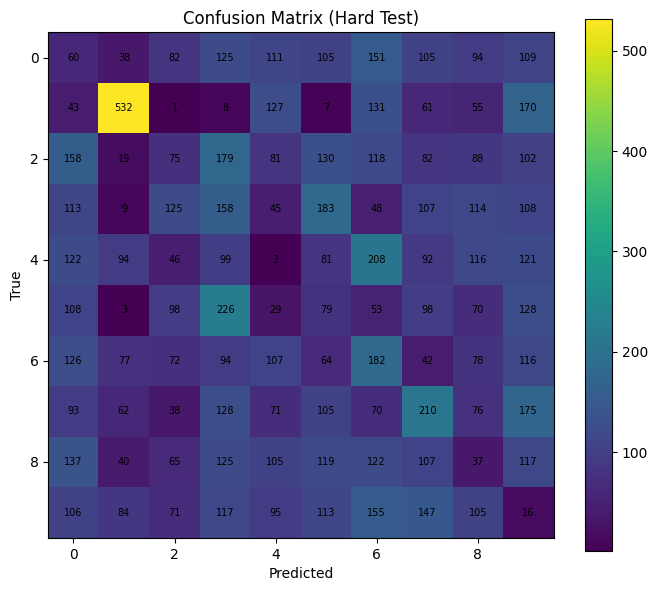

[Task1] Saved confusion matrix -> C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task1\figures\confusion_matrix_hard.png


In [24]:
cm_hard = confusion_matrix(te_pred, te_true)
plot_cm(cm_hard, "Confusion Matrix (Hard Test)")
# also save to disk
plt.figure(figsize=(7,6))
plt.imshow(cm_hard.numpy(), interpolation="nearest")
plt.title("Confusion Matrix (Hard Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
for i in range(10):
    for j in range(10):
        plt.text(j, i, str(int(cm_hard[i,j])), ha="center", va="center", fontsize=7)
plt.tight_layout()
# Use task1_fig_dir if available, otherwise fallback to get_task_figures_dir
if 'task1_fig_dir' in globals():
    fig_path = task1_fig_dir / "confusion_matrix_hard.png"
else:
    fig_path = get_task_figures_dir(1) / "confusion_matrix_hard.png"
save_fig(fig_path)
print(f"[Task1] Saved confusion matrix -> {fig_path}")


Forced-color probe
True digit           : 1
Forced color_id      : 1
Color-associated digit: 1
Total samples        : 1135
----------------------------------------------
Predicted as COLOR digit (1) : 1132
Predicted as TRUE digit  (1) : 1132
Predicted as OTHER digits               : -1129
----------------------------------------------
COLOR shortcut rate = 1132/1135 (99.74%)


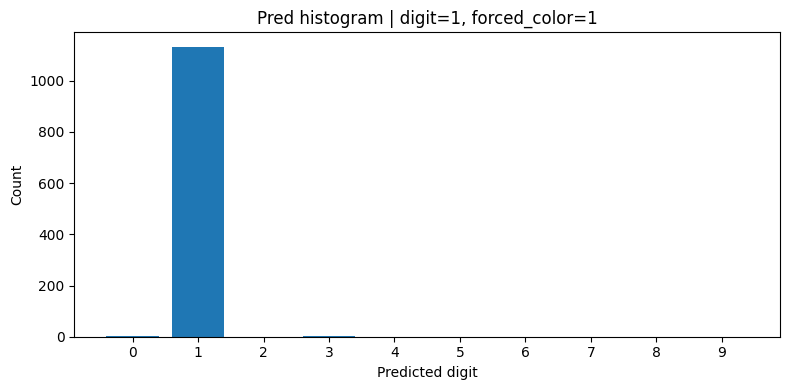


Forced-color probe
True digit           : 2
Forced color_id      : 1
Color-associated digit: 1
Total samples        : 1032
----------------------------------------------
Predicted as COLOR digit (1) : 178
Predicted as TRUE digit  (2) : 3
Predicted as OTHER digits               : 851
----------------------------------------------
COLOR shortcut rate = 178/1032 (17.25%)


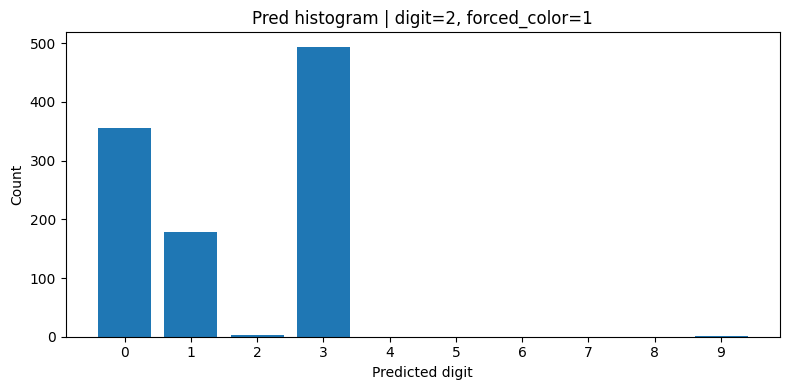


Forced-color probe
True digit           : 3
Forced color_id      : 1
Color-associated digit: 1
Total samples        : 1010
----------------------------------------------
Predicted as COLOR digit (1) : 78
Predicted as TRUE digit  (3) : 871
Predicted as OTHER digits               : 61
----------------------------------------------
COLOR shortcut rate = 78/1010 (7.72%)


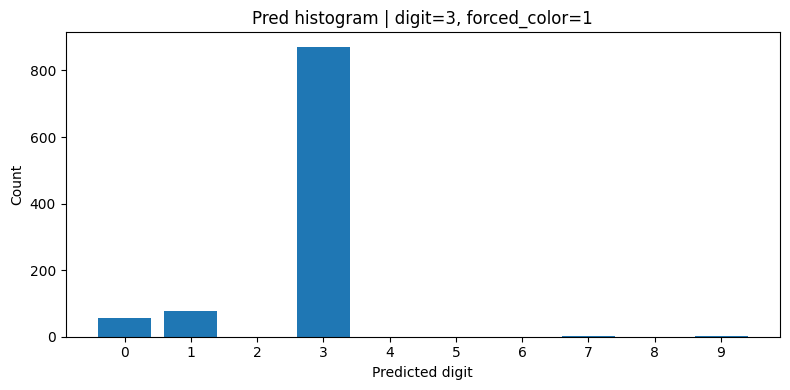


Forced-color probe
True digit           : 4
Forced color_id      : 1
Color-associated digit: 1
Total samples        : 982
----------------------------------------------
Predicted as COLOR digit (1) : 910
Predicted as TRUE digit  (4) : 1
Predicted as OTHER digits               : 71
----------------------------------------------
COLOR shortcut rate = 910/982 (92.67%)


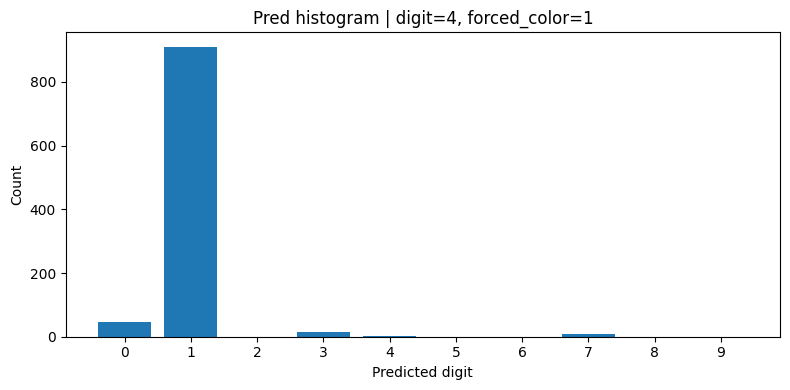


Forced-color probe
True digit           : 5
Forced color_id      : 1
Color-associated digit: 1
Total samples        : 892
----------------------------------------------
Predicted as COLOR digit (1) : 42
Predicted as TRUE digit  (5) : 9
Predicted as OTHER digits               : 841
----------------------------------------------
COLOR shortcut rate = 42/892 (4.71%)


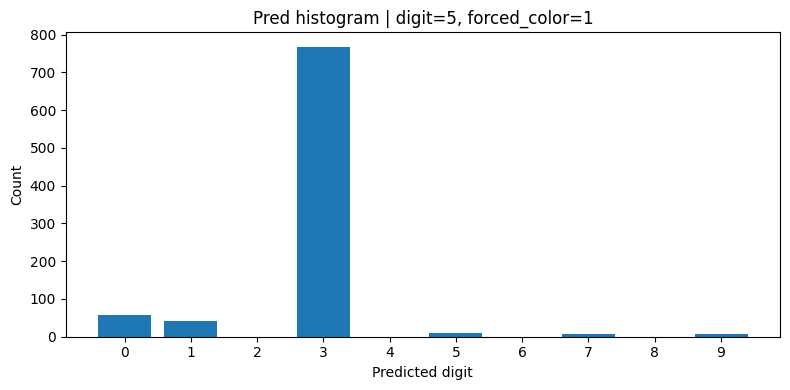


Forced-color probe
True digit           : 6
Forced color_id      : 1
Color-associated digit: 1
Total samples        : 958
----------------------------------------------
Predicted as COLOR digit (1) : 709
Predicted as TRUE digit  (6) : 2
Predicted as OTHER digits               : 247
----------------------------------------------
COLOR shortcut rate = 709/958 (74.01%)


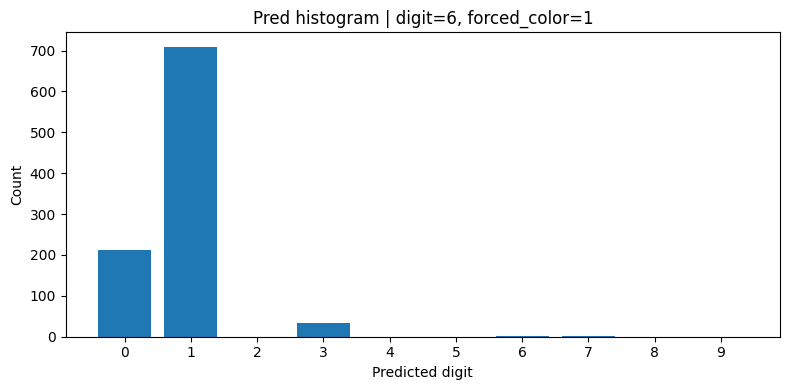


Forced-color probe
True digit           : 7
Forced color_id      : 1
Color-associated digit: 1
Total samples        : 1028
----------------------------------------------
Predicted as COLOR digit (1) : 561
Predicted as TRUE digit  (7) : 334
Predicted as OTHER digits               : 133
----------------------------------------------
COLOR shortcut rate = 561/1028 (54.57%)


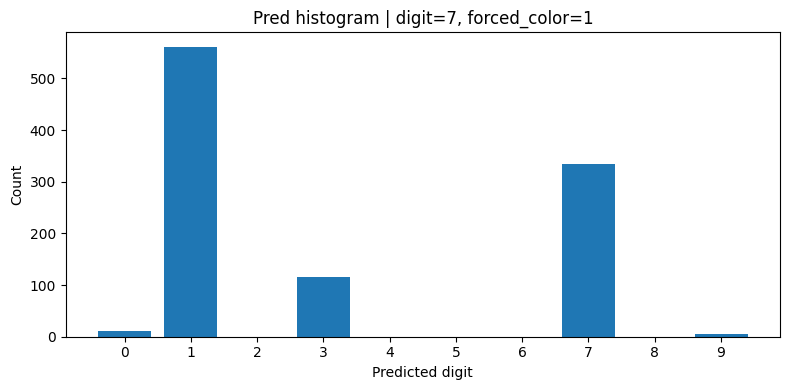


Forced-color probe
True digit           : 8
Forced color_id      : 1
Color-associated digit: 1
Total samples        : 974
----------------------------------------------
Predicted as COLOR digit (1) : 401
Predicted as TRUE digit  (8) : 0
Predicted as OTHER digits               : 573
----------------------------------------------
COLOR shortcut rate = 401/974 (41.17%)


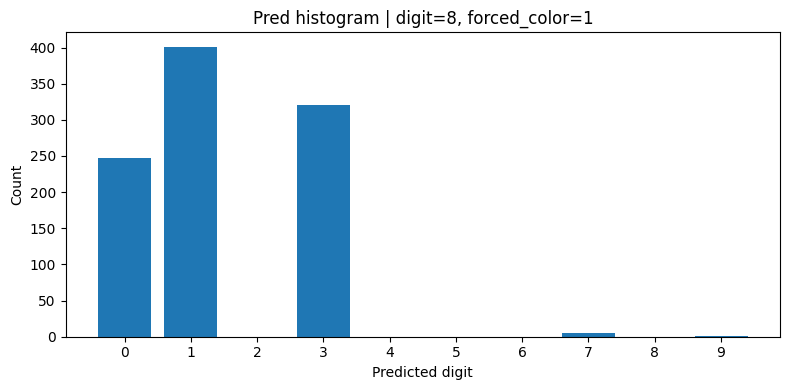


Forced-color probe
True digit           : 9
Forced color_id      : 1
Color-associated digit: 1
Total samples        : 1009
----------------------------------------------
Predicted as COLOR digit (1) : 698
Predicted as TRUE digit  (9) : 2
Predicted as OTHER digits               : 309
----------------------------------------------
COLOR shortcut rate = 698/1009 (69.18%)


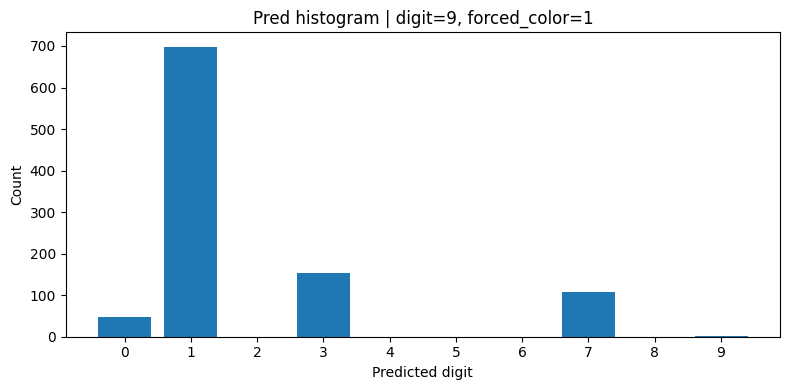

In [25]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt

# same normalization as training
_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

class ForcedColorDigitSet(Dataset):
    """
    Take MNIST, filter to a target digit, recolor ALL samples with a forced color_id.
    Example: target_digit=1, forced_color_id=0 => "Red 1" set.
    """
    def __init__(self, root="./data", base_train=False, target_digit=1, forced_color_id=0, seed=0):
        super().__init__()
        self.base = MNIST(root=root, train=base_train, download=True)
        self.target_digit = int(target_digit)
        self.forced_color_id = int(forced_color_id)
        self.seed = int(seed)

        targets = self.base.targets.numpy()
        self.idxs = np.where(targets == self.target_digit)[0]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, i):
        idx = int(self.idxs[i])
        raw = self.base.data[idx]  # uint8 [28,28]
        y = int(self.base.targets[idx].item())

        np.random.seed(self.seed + idx)

        rgb_uint8 = colorize_digit_textured(raw, COLOUR_MAP[self.forced_color_id])
        img = Image.fromarray(rgb_uint8)
        x = _norm(img)

        return x, y, self.forced_color_id, raw


@torch.no_grad()
def eval_and_pred_hist(model, loader, num_classes=10):
    model.eval()
    pred_counts = np.zeros(num_classes, dtype=np.int64)
    total = 0
    correct = 0

    for x, y, _, _ in loader:
        x = x.to(device)
        y = y.to(device)

        with torch.enable_grad():
            x = x.requires_grad_(True)
            logits = model(x)

        preds = logits.argmax(1)

        correct += (preds == y).sum().item()
        total += y.size(0)

        preds_cpu = preds.detach().cpu().numpy()
        for p in preds_cpu:
            pred_counts[int(p)] += 1

    acc = correct / max(total, 1)
    return acc, pred_counts, total


def plot_pred_hist(counts, title):
    plt.figure(figsize=(8,4))
    plt.bar(np.arange(len(counts)), counts)
    plt.xticks(np.arange(len(counts)))
    plt.title(title)
    plt.xlabel("Predicted digit")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


FORCED_COLOR_ID = 1   # fixed forced color
COLOR_DIGIT = FORCED_COLOR_ID  # <-- assumes color_id maps to digit_id

for TARGET_DIGIT in range(1, 10):

    red1_test = ForcedColorDigitSet(
        root="./data",
        base_train=False,
        target_digit=TARGET_DIGIT,
        forced_color_id=FORCED_COLOR_ID,
        seed=SEED + 999
    )

    red1_loader = DataLoader(red1_test, batch_size=128, shuffle=False)

    acc, pred_counts, total = eval_and_pred_hist(
        model, red1_loader, num_classes=10
    )

    predicted_as_color_digit = pred_counts[COLOR_DIGIT]
    predicted_as_true_digit  = pred_counts[TARGET_DIGIT]
    predicted_as_others      = total - predicted_as_color_digit - predicted_as_true_digit

    print("\n==============================================")
    print(f"Forced-color probe")
    print(f"True digit           : {TARGET_DIGIT}")
    print(f"Forced color_id      : {FORCED_COLOR_ID}")
    print(f"Color-associated digit: {COLOR_DIGIT}")
    print(f"Total samples        : {total}")
    print("----------------------------------------------")
    print(f"Predicted as COLOR digit ({COLOR_DIGIT}) : {predicted_as_color_digit}")
    print(f"Predicted as TRUE digit  ({TARGET_DIGIT}) : {predicted_as_true_digit}")
    print(f"Predicted as OTHER digits               : {predicted_as_others}")
    print("----------------------------------------------")
    print(
        f"COLOR shortcut rate = "
        f"{predicted_as_color_digit}/{total} "
        f"({predicted_as_color_digit/total*100:.2f}%)"
    )
    print("==============================================")

    plot_pred_hist(
        pred_counts,
        title=f"Pred histogram | digit={TARGET_DIGIT}, forced_color={FORCED_COLOR_ID}"
    )

---

## Task 2: The Prober - Neuron Visualization

In [26]:
import os
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw

# Task 2 uses task-based directory structure
# All paths will use get_task_dir() and get_task_figures_dir() functions

def save_fig(path, close=True):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(path, dpi=220, bbox_inches="tight")
    if close:
        plt.close()

def save_json(obj, path):
    import json
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def append_csv(path, row_dict):
    import csv
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    exists = path.exists()
    with open(path, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=list(row_dict.keys()))
        if not exists:
            w.writeheader()
        w.writerow(row_dict)

# Use device and model from notebook globals
device = device if "device" in globals() else ("cuda" if torch.cuda.is_available() else "cpu")
assert "model" in globals(), "You must have `model` defined before running this."
model = model.to(device).eval()

# Use probe dataset from notebook
if "PROBE_DATASET" in globals():
    PROBE_DATASET = PROBE_DATASET
elif "hard_test" in globals():
    PROBE_DATASET = hard_test
elif "full_easy" in globals():
    PROBE_DATASET = full_easy
else:
    raise NameError("Define PROBE_DATASET or have hard_test/full_easy in globals()")

def denorm01(x_bchw):
    # assumes training normalization (x-0.5)/0.5 -> [-1,1]
    return (x_bchw * 0.5 + 0.5).clamp(0, 1)

def total_variation(x):
    return (x[:, :, :, 1:] - x[:, :, :, :-1]).abs().mean() + (x[:, :, 1:, :] - x[:, :, :-1, :]).abs().mean()

def jitter_roll(x, max_jitter=2):
    if max_jitter <= 0:
        return x
    jx = int(np.random.randint(-max_jitter, max_jitter + 1))
    jy = int(np.random.randint(-max_jitter, max_jitter + 1))
    return torch.roll(x, shifts=(jy, jx), dims=(2, 3))

def gaussian_kernel_1d(sigma, radius=None, device="cpu"):
    if sigma <= 0:
        return None
    if radius is None:
        radius = int(max(1, round(3 * sigma)))
    x = torch.arange(-radius, radius + 1, device=device).float()
    k = torch.exp(-(x**2) / (2 * sigma * sigma))
    return k / k.sum()

def gaussian_blur_2d(x_bchw, sigma=0.6):
    if sigma <= 0:
        return x_bchw
    B, C, H, W = x_bchw.shape
    k1 = gaussian_kernel_1d(sigma, device=x_bchw.device)
    kH = k1.view(1, 1, -1, 1)
    kW = k1.view(1, 1, 1, -1)
    x = F.conv2d(x_bchw, kH.repeat(C, 1, 1, 1), padding=(kH.shape[2]//2, 0), groups=C)
    x = F.conv2d(x,     kW.repeat(C, 1, 1, 1), padding=(0, kW.shape[3]//2), groups=C)
    return x

# Safe dataset scanning when ds has no __len__
def ds_has_len(ds):
    return hasattr(ds, "__len__") and callable(getattr(ds, "__len__"))

def safe_len(ds, max_fallback=5000):
    if ds_has_len(ds):
        try:
            return len(ds)
        except TypeError:
            pass
    # fallback: try probing indices until failure (bounded)
    for i in range(max_fallback):
        try:
            _ = ds[i]
        except Exception:
            return i
    return max_fallback

def iter_indices(ds, max_items=5000):
    n = safe_len(ds, max_fallback=max_items)
    for i in range(min(n, max_items)):
        yield i

class ActivationHook:
    def __init__(self, module):
        self.act = None
        self.handle = module.register_forward_hook(self._fn)
    def _fn(self, module, inp, out):
        self.act = out
    def close(self):
        self.handle.remove()

def channel_objective_single(acts, ch, mode="channel_max", topk=32):
    """
    acts: [1,C,H,W] or [1,C]
    """
    if acts.dim() == 4:
        m = acts[0, ch]  # [H,W]
        if mode == "channel_max":
            return m.max()
        if mode == "channel_mean":
            return m.mean()
        if mode == "topk_mean":
            v = m.flatten()
            return torch.topk(v, min(topk, v.numel())).values.mean()
        raise KeyError(mode)
    if acts.dim() == 2:
        return acts[0, ch]
    raise ValueError(f"Unsupported activation shape: {acts.shape}")

@torch.no_grad()
def activation_map_for_proto(model, module, x_1chw, ch, upsample_to=28):
    """
    returns [1,1,upsample_to,upsample_to] in [0,1]
    """
    hook = ActivationHook(module)
    _ = model(x_1chw.to(device))
    a = hook.act
    hook.close()

    if a.dim() == 4:
        m = a[0, ch]
        m = m - m.min()
        m = m / (m.max() + 1e-8)
        m = F.interpolate(m[None, None], (upsample_to, upsample_to), mode="bilinear", align_corners=False)
        return m
    if a.dim() == 2:
        v = a[0, ch]
        v = torch.tanh(v / 5) * 0.5 + 0.5
        return torch.full((1, 1, upsample_to, upsample_to), float(v), device=device)
    raise ValueError(f"Unsupported activation shape: {a.shape}")

def overlay_heat(proto_1chw, act_1hw, alpha=0.45):
    """
    proto_1chw: [1,3,28,28] in [-1,1]
    act_1hw:    [1,1,28,28] in [0,1]
    returns HxWx3 in [0,1]
    """
    proto = denorm01(proto_1chw).detach()[0].permute(1, 2, 0).cpu().numpy()
    heat = plt.cm.inferno(act_1hw.detach()[0, 0].cpu().numpy())[..., :3]
    return np.clip((1 - alpha) * proto + alpha * heat, 0, 1)

@torch.no_grad()
def pick_channel_by_dataset_mean(model, module, C, ds, max_n=600):
    """
    Picks a single channel per layer by highest mean activation over a probe subset.
    Works even if ds has no __len__.
    """
    hook = ActivationHook(module)
    s = torch.zeros(C, device=device)
    n = 0
    for i in iter_indices(ds, max_items=max_n):
        x = ds[i][0].unsqueeze(0).to(device)
        _ = model(x)
        a = hook.act
        if a is None:
            continue
        if a.dim() == 4:
            s += a.mean(dim=(0, 2, 3))
        elif a.dim() == 2:
            s += a.mean(dim=0)
        else:
            hook.close()
            raise ValueError(f"Unsupported activation shape: {a.shape}")
        n += 1
    hook.close()
    if n == 0:
        return 0
    return int(s.argmax().item())

def optimize_one_proto(model, module, ch, mode, x0,
                       steps=200, lr=0.08, jitter=2,
                       l2_weight=1e-4, tv_weight=2e-4):
    hook = ActivationHook(module)
    x = x0.clone().requires_grad_(True)
    opt = torch.optim.Adam([x], lr=lr)

    best, best_x = -1e9, x.detach().clone()
    for t in range(steps):
        opt.zero_grad(set_to_none=True)
        x_in = jitter_roll(x, jitter)
        _ = model(x_in)
        obj = channel_objective_single(hook.act, ch, mode=mode)
        loss = -obj + l2_weight * (x**2).mean() + tv_weight * total_variation(x)
        loss.backward()
        opt.step()

        with torch.no_grad():
            x.clamp_(-1, 1)
            v = float(obj.item())
            if v > best:
                best = v
                best_x = x.detach().clone()

    hook.close()
    return best_x

def run_oneproto_sheet(model, ds, layers, modes,
                       out_dir, title="Task 2 — One-prototype comparison",
                       seed_base=100, overlay_alpha=0.45):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    
    # Check if output already exists
    sheet_path = out_dir / "task2__oneproto__sheet.png"
    if sheet_path.exists():
        print(f"[Task2:A] SKIP - One-proto sheet already exists -> {sheet_path}")
        return sheet_path

    cells = {}
    picked = {}

    for i, (lname, lmod, C) in enumerate(layers):
        ch = pick_channel_by_dataset_mean(model, lmod, C, ds, max_n=600)
        picked[lname] = ch

        torch.manual_seed(seed_base + i)
        x0 = torch.randn(1, 3, 28, 28, device=device) * 0.2

        for mode in modes:
            proto = optimize_one_proto(model, lmod, ch, mode, x0)
            act = activation_map_for_proto(model, lmod, proto, ch, upsample_to=28)
            img = overlay_heat(proto, act, alpha=overlay_alpha)
            cells[(lname, mode)] = img
            plt.imsave(out_dir / f"cell__{lname}__ch{ch}__{mode}.png", img)

    np.save(out_dir / "selected_channels.npy", picked)

    R, Cc = len(layers), len(modes)
    fig, axes = plt.subplots(R, Cc, figsize=(3.6 * Cc, 2.8 * R))

    for j, m in enumerate(modes):
        axes[0, j].set_title(m, fontsize=12)

    for i, (lname, _, _) in enumerate(layers):
        for j, m in enumerate(modes):
            axes[i, j].imshow(cells[(lname, m)])
            axes[i, j].axis("off")

    for i, (lname, _, _) in enumerate(layers):
        y = 1 - (i + 0.5) / R
        fig.text(0.02, y, lname, va="center", ha="left", fontsize=11)

    plt.suptitle(f"{title} (rows = layers, cols = objectives)", fontsize=14)
    plt.subplots_adjust(left=0.12, top=0.96, wspace=0.05, hspace=0.05)

    sheet_path = out_dir / "task2__oneproto__sheet.png"
    plt.savefig(sheet_path, dpi=220)
    plt.close()
    print(f"[Task2:A] One-proto sheet -> {sheet_path}")
    return sheet_path

def channel_objective_batch(acts, channels, mode="channel_max", topk=32):
    """
    acts: [B,C,H,W] or [B,C]
    channels: list length B mapping each item to its target channel
    """
    B = acts.shape[0]
    ch = torch.as_tensor(channels, device=acts.device, dtype=torch.long)

    if acts.dim() == 4:
        sel = acts[torch.arange(B, device=acts.device), ch] 
        if mode == "channel_mean":
            obj_per = sel.mean(dim=(1, 2))
        elif mode == "channel_max":
            obj_per = sel.amax(dim=(1, 2))
        elif mode == "topk_mean":
            flat = sel.flatten(1)
            k = min(topk, flat.shape[1])
            vals, _ = torch.topk(flat, k, dim=1)
            obj_per = vals.mean(dim=1)
        else:
            raise KeyError(mode)
        return obj_per.mean(), obj_per

    if acts.dim() == 2:
        sel = acts[torch.arange(B, device=acts.device), ch]
        obj_per = sel
        return obj_per.mean(), obj_per

    raise ValueError(f"Unsupported activation shape: {acts.shape}")

def feature_viz_batch(model, hook_module, channels, mode="channel_max",
                      steps=200, lr=0.08, seed=0,
                      clamp=(-1, 1), l2_weight=1e-4, tv_weight=2e-4,
                      jitter=2, blur_every=8, blur_sigma=0.6,
                      topk=32, print_every=50):
    torch.manual_seed(seed)
    np.random.seed(seed)
    model.eval()
    hook = ActivationHook(hook_module)

    B = len(channels)
    x = torch.randn(B, 3, 28, 28, device=device) * 0.2
    x.requires_grad_(True)
    opt = torch.optim.Adam([x], lr=lr)

    best_obj = torch.full((B,), -1e9, device=device)
    best_x = x.detach().clone()

    for t in range(1, steps + 1):
        opt.zero_grad(set_to_none=True)
        x_in = jitter_roll(x, jitter)
        _ = model(x_in)
        acts = hook.act
        obj, obj_per = channel_objective_batch(acts, channels, mode=mode, topk=topk)

        loss = -obj + l2_weight * (x**2).mean() + tv_weight * total_variation(x)
        loss.backward()
        opt.step()

        with torch.no_grad():
            if blur_every and (t % blur_every == 0):
                x.copy_(gaussian_blur_2d(x, sigma=blur_sigma))
            x.clamp_(clamp[0], clamp[1])

            improved = obj_per > best_obj
            if improved.any():
                best_obj[improved] = obj_per[improved]
                best_x[improved] = x.detach()[improved]

        if (t == 1) or (t % print_every == 0) or (t == steps):
            print(f"[Task2:B] {hook_module.__class__.__name__} mode={mode} step {t}/{steps} obj={float(obj):.4f}")

    hook.close()
    return best_x.detach(), best_obj.detach()

@torch.no_grad()
def activation_maps_for_batch(model, hook_module, x_bchw, channels, upsample_to=28):
    model.eval()
    hook = ActivationHook(hook_module)
    _ = model(x_bchw.to(device))
    acts = hook.act
    hook.close()

    B = acts.shape[0]
    ch = torch.as_tensor(channels, device=acts.device, dtype=torch.long)

    if acts.dim() == 4:
        sel = acts[torch.arange(B, device=acts.device), ch].unsqueeze(1)  # [B,1,H,W]
        sel = sel - sel.amin(dim=(2, 3), keepdim=True)
        sel = sel / (sel.amax(dim=(2, 3), keepdim=True) + 1e-8)
        if upsample_to is not None and (sel.shape[2] != upsample_to or sel.shape[3] != upsample_to):
            sel = F.interpolate(sel, size=(upsample_to, upsample_to), mode="bilinear", align_corners=False)
        return sel

    if acts.dim() == 2:
        sel = acts[torch.arange(B, device=acts.device), ch].view(B, 1, 1, 1)
        sel_min, sel_max = sel.min(), sel.max()
        sel = (sel - sel_min) / (sel_max - sel_min + 1e-8)
        if upsample_to is not None:
            sel = F.interpolate(sel, size=(upsample_to, upsample_to), mode="nearest")
        return sel

    raise ValueError(f"Unsupported activation shape: {acts.shape}")

def grid_to_numpy01(x_bchw, nrow):
    g = make_grid(denorm01(x_bchw.detach().cpu()), nrow=nrow, padding=2)
    return np.clip(g.permute(1, 2, 0).numpy(), 0, 1)

def save_featureviz_grid(layer_name, mode, x_bchw, act_b1hw, nrow, out_path):
    img_grid = grid_to_numpy01(x_bchw, nrow=nrow)

    act3 = act_b1hw.repeat(1, 3, 1, 1).detach().cpu()
    act_grid = make_grid(act3, nrow=nrow, padding=2).permute(1, 2, 0).numpy()
    act_grid = np.clip(act_grid, 0, 1)

    plt.figure(figsize=(max(10, nrow * 1.2), 8))
    plt.suptitle(f"{layer_name} | {mode}", y=0.99)

    plt.subplot(2, 1, 1)
    plt.title("Optimized images (each tile targets one channel)")
    plt.imshow(img_grid); plt.axis("off")

    plt.subplot(2, 1, 2)
    plt.title("Activation maps for the targeted channel (upsampled to 28x28)")
    plt.imshow(act_grid); plt.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    save_fig(out_path, close=True)
    print(f"[Task2:B] saved grid -> {out_path}")

@torch.no_grad()
def top_activating_examples(model, hook_module, dataset, channel, k=8,
                           score_mode="channel_mean", max_scan=3000):
    model.eval()
    hook = ActivationHook(hook_module)

    scores = []
    idxs = []
    seen = 0
    for i in iter_indices(dataset, max_items=max_scan):
        x, y, c, raw = dataset[i]
        xb = x.unsqueeze(0).to(device)
        _ = model(xb)
        acts = hook.act

        if acts.dim() == 4:
            a = acts[0, channel]
            s = float(a.mean().item()) if score_mode == "channel_mean" else float(a.max().item())
        elif acts.dim() == 2:
            s = float(acts[0, channel].item())
        else:
            hook.close()
            raise ValueError(f"Unsupported activation shape: {acts.shape}")

        scores.append(s)
        idxs.append(i)
        seen += 1
        if seen >= max_scan:
            break

    hook.close()
    top = np.argsort(scores)[-k:][::-1]
    return [idxs[j] for j in top], [scores[j] for j in top]

def save_microscope_panel(layer_name, hook_module, dataset, channel, proto_norm_1chw, out_path, k=8):
    proto = denorm01(proto_norm_1chw)[0].permute(1, 2, 0).detach().cpu().numpy()
    top_idx, top_scores = top_activating_examples(model, hook_module, dataset, channel, k=k, max_scan=3000)

    plt.figure(figsize=(2.2 * (k + 1), 2.8))
    plt.suptitle(f"{layer_name} ch{channel} | prototype + top dataset examples", y=1.05)

    plt.subplot(1, k + 1, 1)
    plt.imshow(proto); plt.title("Prototype"); plt.axis("off")

    for j, idx in enumerate(top_idx):
        x, y, c, _ = dataset[idx]
        img = denorm01(x.unsqueeze(0))[0].permute(1, 2, 0).cpu().numpy()
        plt.subplot(1, k + 1, j + 2)
        plt.imshow(img)
        plt.title(f"y={y}, c={c}\n{top_scores[j]:.2f}", fontsize=8)
        plt.axis("off")

    plt.tight_layout()
    save_fig(out_path, close=True)
    print(f"[Task2:B] saved microscope panel -> {out_path}")

def run_task2_all_layers(model, layers, modes=("channel_max", "channel_mean", "topk_mean"),
                         steps=200, lr=0.08, chunk_size=32, seed=0, nrow=16,
                         make_microscope=True, microscope_dataset=None,
                         microscope_channels_per_layer=4,
                         out_dir=None, metrics_csv=None, task_num=2):
    # Use task-specific directory if not provided
    if out_dir is None:
        task2_fig_dir = get_task_figures_dir(task_num)
        out_dir = task2_fig_dir / "allchannels"
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    
    # Use task-specific metrics path if not provided
    if metrics_csv is None:
        task2_dir = get_task_dir(task_num)
        metrics_csv = task2_dir / "metrics.json"
    metrics_csv = Path(metrics_csv)

    cfg = dict(modes=list(modes), steps=steps, lr=lr, chunk_size=chunk_size, seed=seed, nrow=nrow)
    # Save config to task2 directory
    task2_dir = get_task_dir(task_num)
    save_json(cfg, task2_dir / "config.json")

    # Check which layer/mode combos already exist
    existing = set()
    for (lname, _, _) in layers:
        for mode in modes:
            out_path = out_dir / f"{lname}__{mode}__all_channels.png"
            if out_path.exists():
                existing.add((lname, mode))
                print(f"[Task2:B] SKIP - {lname}/{mode} already exists -> {out_path}")

    for (lname, lmodule, C) in layers:
        for mode in modes:
            # Skip if already exists
            if (lname, mode) in existing:
                continue
            all_imgs = []
            all_objs = []
            chs = list(range(C))

            for s in range(0, C, chunk_size):
                chunk = chs[s:s + chunk_size]
                xb, ob = feature_viz_batch(
                    model, lmodule, chunk, mode=mode,
                    steps=steps, lr=lr, seed=seed + s,
                    tv_weight=2e-4, l2_weight=1e-4,
                    jitter=2, blur_every=8, blur_sigma=0.6,
                    topk=32, print_every=max(50, steps // 4)
                )
                all_imgs.append(xb)
                all_objs.append(ob)

                for i, ch in enumerate(chunk):
                    append_csv(metrics_csv, {
                        "layer": lname,
                        "mode": mode,
                        "channel": int(ch),
                        "best_obj": float(ob[i].item()),
                        "seed": int(seed + s),
                        "steps": int(steps),
                    })

            x_all = torch.cat(all_imgs, dim=0)
            obj_all = torch.cat(all_objs, dim=0)

            act_maps = activation_maps_for_batch(model, lmodule, x_all.to(device), channels=list(range(C)), upsample_to=28)

            out_path = out_dir / f"{lname}__{mode}__all_channels.png"
            save_featureviz_grid(lname, mode, x_all, act_maps, nrow=nrow, out_path=out_path)

            if make_microscope and (microscope_dataset is not None):
                topk = int(microscope_channels_per_layer)
                top_ch = torch.topk(obj_all, k=min(topk, C)).indices.detach().cpu().tolist()
                for ch in top_ch:
                    proto = x_all[ch:ch + 1]
                    panel_path = out_dir / f"microscope__{lname}__ch{ch}.png"
                    save_microscope_panel(lname, lmodule, microscope_dataset, ch, proto, panel_path, k=8)

    print(f"[Task2:B] DONE. Grids in: {out_dir} | Metrics: {metrics_csv}")
    return out_dir

def stitch_task2_comparison_sheet(task2_dir, layer_names, modes,
                                  out_path, pad=18, header_h=50, left_w=140,
                                  bg=(255, 255, 255)):
    task2_dir = Path(task2_dir)
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    grid_imgs = []
    for lname in layer_names:
        row = []
        for mode in modes:
            p = task2_dir / f"{lname}__{mode}__all_channels.png"
            if not p.exists():
                raise FileNotFoundError(f"Missing: {p}")
            row.append(Image.open(p).convert("RGB"))
        grid_imgs.append(row)

    cell_w = max(im.width for row in grid_imgs for im in row)
    cell_h = max(im.height for row in grid_imgs for im in row)

    R = len(layer_names)
    Cc = len(modes)

    W = left_w + Cc * cell_w + (Cc + 1) * pad
    H = header_h + R * cell_h + (R + 1) * pad

    canvas = Image.new("RGB", (W, H), bg)
    draw = ImageDraw.Draw(canvas)

    # column labels
    for j, mode in enumerate(modes):
        x0 = left_w + pad + j * (cell_w + pad)
        draw.text((x0 + 6, 10), mode, fill=(0, 0, 0))

    # rows
    for i, lname in enumerate(layer_names):
        y0 = header_h + pad + i * (cell_h + pad)
        draw.text((10, y0 + 10), lname, fill=(0, 0, 0))
        for j in range(Cc):
            x0 = left_w + pad + j * (cell_w + pad)
            im = grid_imgs[i][j]
            if im.size != (cell_w, cell_h):
                tmp = Image.new("RGB", (cell_w, cell_h), bg)
                tmp.paste(im, (0, 0))
                im = tmp
            canvas.paste(im, (x0, y0))

    canvas.save(out_path)
    print(f"[Task2:B] stitched sheet -> {out_path}")
    return out_path

class ColorFiltered(Dataset):
    def __init__(self, base_ds, target_c, max_scan=200000):
        self.base = base_ds
        self.target_c = int(target_c)
        self.idxs = []
        for i in iter_indices(base_ds, max_items=max_scan):
            try:
                _, _, c, _ = base_ds[i]
            except Exception:
                continue
            if int(c) == self.target_c:
                self.idxs.append(i)
    def __len__(self):
        return len(self.idxs)
    def __getitem__(self, j):
        return self.base[self.idxs[j]]

def get_tint_rgb01_for_c(target_c, default=(1.0, 0.0, 0.0)):
    if "COLOUR_MAP" in globals():
        rgb = globals()["COLOUR_MAP"][int(target_c)]
        rgb01 = (rgb.astype(np.float32) / 255.0).tolist()
        return tuple(rgb01)
    return default

def activation_at_point(model, x, point: str):
    z = model.conv1(x)
    if point == "conv1": return z
    z = model.relu1(z)
    if point == "relu1": return z
    z = model.pool1(z)
    if point == "pool1": return z

    z = model.conv2(z)
    if point == "conv2": return z
    z = model.relu2(z)
    if point == "relu2": return z
    z = model.pool2(z)
    if point == "pool2": return z

    z = model.conv3(z)
    if point == "conv3": return z
    z = model.relu3(z)
    if point == "relu3": return z

    z = model.gap(z)          # [B,C,1,1]
    if point == "gap": return z

    z = z.flatten(1)
    z = model.fc(z)           # [B,10]
    if point == "fc": return z

    raise KeyError(f"Unknown point: {point}")

class OneColorImage(nn.Module):
    def __init__(self, B, H, W, tint_rgb01, bg_rgb01=(0.5, 0.5, 0.5), init_scale=0.2, device="cpu"):
        super().__init__()
        self.raw = nn.Parameter(torch.randn(B, 1, H, W, device=device) * init_scale)
        self.register_buffer("tint01", torch.tensor(tint_rgb01, device=device).view(1, 3, 1, 1))
        self.register_buffer("bg01",   torch.tensor(bg_rgb01,   device=device).view(1, 3, 1, 1))

    def forward(self):
        a = torch.sigmoid(self.raw)  # [B,1,H,W] in [0,1]
        x01 = self.bg01 + a * (self.tint01 - self.bg01)  # forced single hue
        x01 = x01.clamp(0, 1)
        x = (x01 * 2.0 - 1.0).clamp(-1, 1)               # back to model space
        return x

def channel_objective_point(acts, channels, mode="channel_max", topk=32):
    B = acts.shape[0]
    ch = torch.as_tensor(channels, device=acts.device, dtype=torch.long)

    if acts.ndim == 4:
        sel = acts[torch.arange(B, device=acts.device), ch]  # [B,H,W]
        if mode == "channel_mean":
            obj_per = sel.mean(dim=(1, 2))
        elif mode == "channel_max":
            obj_per = sel.amax(dim=(1, 2))
        elif mode == "topk_mean":
            flat = sel.flatten(1)
            k = min(topk, flat.shape[1])
            vals, _ = torch.topk(flat, k, dim=1)
            obj_per = vals.mean(dim=1)
        else:
            raise KeyError(mode)
        return obj_per.mean(), obj_per

    if acts.ndim == 2:
        sel = acts[torch.arange(B, device=acts.device), ch]
        obj_per = sel
        return obj_per.mean(), obj_per

    raise ValueError(f"Unsupported activation shape: {acts.shape}")

def feature_viz_onecolor(model, point, channels, tint_rgb01,
                         mode="channel_max", steps=200, lr=0.08, seed=0,
                         l2_weight=1e-4, tv_weight=2e-4,
                         jitter=2, blur_every=8, blur_sigma=0.6, topk=32,
                         print_every=50):
    np.random.seed(seed)
    torch.manual_seed(seed)
    model.eval()

    B = len(channels)
    gen = OneColorImage(B, 28, 28, tint_rgb01=tint_rgb01, device=device)
    opt = torch.optim.Adam(gen.parameters(), lr=lr)

    best_obj = torch.full((B,), -1e9, device=device)
    best_x = gen().detach().clone()

    for t in range(1, steps + 1):
        opt.zero_grad(set_to_none=True)

        x = gen()
        x_in = jitter_roll(x, jitter)

        acts = activation_at_point(model, x_in, point)
        obj, obj_per = channel_objective_point(acts, channels, mode=mode, topk=topk)

        loss = -obj + l2_weight * (x**2).mean() + tv_weight * total_variation(x)
        loss.backward()
        opt.step()

        with torch.no_grad():
            if blur_every and (t % blur_every == 0):
                gen.raw.data = gaussian_blur_2d(gen.raw.data, sigma=blur_sigma)
            x_now = gen().detach()
            improved = obj_per > best_obj
            if improved.any():
                best_obj[improved] = obj_per[improved]
                best_x[improved] = x_now[improved]

        if (t == 1) or (t % print_every == 0) or (t == steps):
            print(f"[Task2:C] onecolor point={point} mode={mode} step {t}/{steps} obj={float(obj):.4f}")

    return best_x.detach(), best_obj.detach()

@torch.no_grad()
def activation_maps_onecolor(model, point, x_bchw, channels, upsample_to=28):
    acts = activation_at_point(model, x_bchw.to(device), point)
    B = acts.shape[0]
    ch = torch.as_tensor(channels, device=acts.device, dtype=torch.long)

    if acts.ndim == 4:
        sel = acts[torch.arange(B, device=acts.device), ch].unsqueeze(1)
        sel = sel - sel.amin(dim=(2, 3), keepdim=True)
        sel = sel / (sel.amax(dim=(2, 3), keepdim=True) + 1e-8)
        if sel.shape[-1] != upsample_to:
            sel = F.interpolate(sel, size=(upsample_to, upsample_to), mode="bilinear", align_corners=False)
        return sel

    if acts.ndim == 2:
        sel = acts[torch.arange(B, device=acts.device), ch]
        sel = sel - sel.min()
        sel = sel / (sel.max() + 1e-8)
        sel = sel.view(B, 1, 1, 1).expand(B, 1, upsample_to, upsample_to).contiguous()
        return sel

    raise ValueError(f"Unsupported activation shape: {acts.shape}")

@torch.no_grad()
def top_channels_on_color(model, point, outC, color_ds, take=12, max_scan=2000, batch_size=128):
    loader = DataLoader(color_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    sums = torch.zeros(outC, device=device)
    seen = 0

    for (x, y, c, raw) in loader:
        x = x.to(device)
        acts = activation_at_point(model, x, point)
        if acts.ndim == 4:
            v = acts.mean(dim=(0, 2, 3))
        else:
            v = acts.mean(dim=0)
        sums += v
        seen += x.shape[0]
        if seen >= max_scan:
            break

    means = sums / max(1, (seen / batch_size))
    k = min(int(take), outC)
    return torch.topk(means, k=k).indices.detach().cpu().tolist()

def cell_image_proto_and_act(x_bchw, act_b1hw, nrow=6):
    proto = make_grid(denorm01(x_bchw.detach().cpu()), nrow=nrow, padding=2)
    act3  = act_b1hw.repeat(1, 3, 1, 1).detach().cpu()
    act   = make_grid(act3, nrow=nrow, padding=2)

    proto_np = np.clip(proto.permute(1, 2, 0).numpy(), 0, 1)
    act_np   = np.clip(act.permute(1, 2, 0).numpy(),   0, 1)

    gap = np.ones((10, proto_np.shape[1], 3), dtype=np.float32)
    return np.concatenate([proto_np, gap, act_np], axis=0)

def run_onecolor_overview(model, base_dataset_for_scan, TARGET_C=0,
                          modes=("channel_max", "channel_mean", "topk_mean"),
                          steps=200, lr=0.08, per_layer_channels=12, nrow=6, max_scan=2000,
                          out_dir=None, task_num=2):
    # Use task-specific directory if not provided
    if out_dir is None:
        task2_fig_dir = get_task_figures_dir(task_num)
        out_dir = task2_fig_dir / "onecolor"
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    
    # Check if output already exists
    out_path = out_dir / f"task2_onecolor_overview__c{TARGET_C}.png"
    if out_path.exists():
        print(f"[Task2:C] SKIP - One-color overview already exists -> {out_path}")
        return out_path

    color_ds = ColorFiltered(base_dataset_for_scan, TARGET_C)
    print(f"[Task2:C] Using only c={TARGET_C}; filtered size={len(color_ds)}")

    tint_rgb01 = get_tint_rgb01_for_c(TARGET_C, default=(1.0, 0.0, 0.0))
    print(f"[Task2:C] tint rgb01 = {tint_rgb01}")

    layers = [
        ("conv1", 32), ("relu1", 32), ("pool1", 32),
        ("conv2", 64), ("relu2", 64), ("pool2", 64),
        ("conv3", 128), ("relu3", 128),
        ("gap", 128),
        ("fc", 10),
    ]

    R = len(layers)
    Cc = len(modes)
    plt.figure(figsize=(5.8 * Cc, 2.3 * R))
    plt.suptitle(f"Task 2 — One-color overview (c={TARGET_C})", y=1.02)

    for r, (lname, outC) in enumerate(layers):
        if lname == "fc":
            chosen = list(range(outC))
        else:
            chosen = top_channels_on_color(model, lname, outC, color_ds,
                                           take=per_layer_channels, max_scan=max_scan)

        for c, mode in enumerate(modes):
            xb, ob = feature_viz_onecolor(
                model, lname, chosen, tint_rgb01,
                mode=mode, steps=steps, lr=lr,
                seed=1000 + 31 * r + 97 * c,
                print_every=max(50, steps // 4),
                blur_every=8, blur_sigma=0.6
            )

            act = activation_maps_onecolor(model, lname, xb, chosen, upsample_to=28)
            cell = cell_image_proto_and_act(xb, act, nrow=nrow)

            ax = plt.subplot(R, Cc, r * Cc + c + 1)
            ax.imshow(cell)
            ax.axis("off")

            # column labels
            if r == 0:
                ax.set_title(mode, fontsize=12)
            # row labels (layer names) on leftmost col
            if c == 0:
                ax.text(-0.02, 0.5, lname, transform=ax.transAxes,
                        rotation=90, va="center", ha="right", fontsize=12)

    plt.tight_layout()
    out_path = out_dir / f"task2_onecolor_overview__c{TARGET_C}.png"
    save_fig(out_path, close=True)
    print(f"[Task2:C] saved -> {out_path}")
    return out_path

layers_all = [
    ("conv1", model.conv1, model.conv1.out_channels),
    ("relu1", model.relu1, model.conv1.out_channels),
    ("pool1", model.pool1, model.conv1.out_channels),

    ("conv2", model.conv2, model.conv2.out_channels),
    ("relu2", model.relu2, model.conv2.out_channels),
    ("pool2", model.pool2, model.conv2.out_channels),

    ("conv3", model.conv3, model.conv3.out_channels),
    ("relu3", model.relu3, model.conv3.out_channels),

    ("gap",  model.gap, model.conv3.out_channels),
    ("fc",   model.fc,  model.fc.out_features),
]

modes = ("channel_max", "channel_mean", "topk_mean")

TASK2_NUM = 2
task2_fig_dir = get_task_figures_dir(TASK2_NUM)

OUT_A = task2_fig_dir / "oneproto"
sheet_oneproto = run_oneproto_sheet(
    model=model,
    ds=PROBE_DATASET,
    layers=layers_all,
    modes=modes,
    out_dir=OUT_A,
    title="Task 2 — One-prototype comparison",
    seed_base=100,
    overlay_alpha=0.45
)

OUT_B = task2_fig_dir / "allchannels"
task2_dir_obj = get_task_dir(TASK2_NUM)
metrics_csv = task2_dir_obj / "metrics.json"

task2_dir = run_task2_all_layers(
    model=model,
    layers=layers_all,
    modes=modes,
    steps=200,
    lr=0.08,
    chunk_size=32,
    seed=0,
    nrow=16,
    make_microscope=True,
    microscope_dataset=PROBE_DATASET,     #set hard_test explicitly if you want
    microscope_channels_per_layer=4,
    out_dir=OUT_B,
    metrics_csv=metrics_csv
)

sheet_all = stitch_task2_comparison_sheet(
    task2_dir=task2_dir,
    layer_names=[x[0] for x in layers_all],
    modes=modes,
    out_path=Path(task2_dir) / "task2__comparison_sheet_labeled.png"
)

OUT_C = task2_fig_dir / "onecolor"
TARGET_C = 0
sheet_onecolor = run_onecolor_overview(
    model=model,
    base_dataset_for_scan=PROBE_DATASET,  # or hard_test / full_easy
    TARGET_C=TARGET_C,
    modes=modes,
    steps=200,
    lr=0.08,
    per_layer_channels=12,
    nrow=6,
    max_scan=2000,
    out_dir=OUT_C,
    task_num=TASK2_NUM
)

print("\n=== SAVED OUTPUTS ===")
print("A) One-proto labeled sheet:", sheet_oneproto)
print("B) All-channels stitched labeled sheet:", sheet_all)
print("C) One-color overview labeled sheet:", sheet_onecolor)
print("B) Microscope panels + grids folder:", task2_dir)
print("B) Metrics CSV:", metrics_csv)


[Task2:A] SKIP - One-proto sheet already exists -> C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task2\figures\oneproto\task2__oneproto__sheet.png
[Task2:B] SKIP - conv1/channel_max already exists -> C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task2\figures\allchannels\conv1__channel_max__all_channels.png
[Task2:B] SKIP - conv1/channel_mean already exists -> C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task2\figures\allchannels\conv1__channel_mean__all_channels.png
[Task2:B] SKIP - conv1/topk_mean already exists -> C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task2\figures\allchannels\conv1__topk_mean__all_channels.png
[Task2:B] SKIP - relu1/channel_max already exists -> C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task2\figures\allchannels\relu1__channel_max__all_channels.png
[Task2:B] SKIP - relu1/channel_mean already exists -> C:\Users\anush\Downloads\notebook_repo

---

## Task 3: The Interrogation - Grad-CAM Implementation

In [27]:
def normalize_like_train(x01_bchw):
    """Convert [0,1] image to normalized [-1,1] like training"""
    return (x01_bchw - 0.5) / 0.5

In [28]:
def find_raw_digit_from_dataset(ds_obj, digit):
    for i in range(len(ds_obj)):
        _, y, _, raw = ds_obj[i]
        if int(y) == digit:
            return raw
    raise RuntimeError("Digit not found")

DIGIT = 0
raw0 = find_raw_digit_from_dataset(full_easy, DIGIT)

biased_np      = colorize_digit_textured(raw0, COLOUR_MAP[0])  # Red 0
conflict_np    = colorize_digit_textured(raw0, COLOUR_MAP[1])  # Green 0

# Convert to torch [3,H,W] in [0,1] for display
biased01   = torch.from_numpy(biased_np).permute(2,0,1).float() / 255.0
conf01     = torch.from_numpy(conflict_np).permute(2,0,1).float() / 255.0

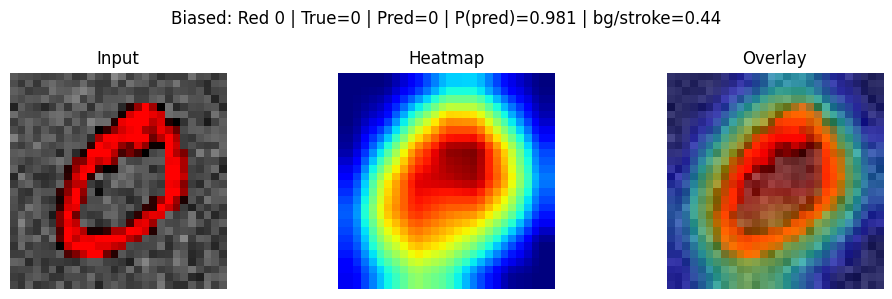

Biased: Red 0: bg_mean=0.3273, stroke_mean=0.7355, bg/stroke=0.44


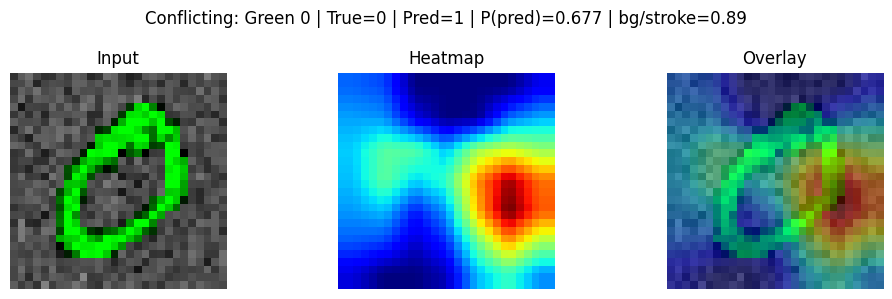

Conflicting: Green 0: bg_mean=0.3196, stroke_mean=0.3576, bg/stroke=0.89
[skip] pytorch-grad-cam not installed. Install with: pip install grad-cam


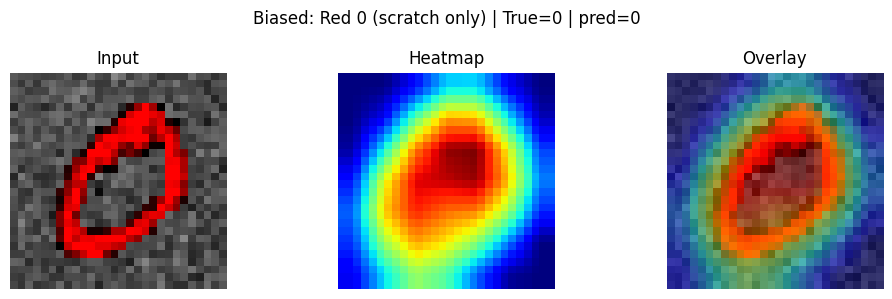

[skip] pytorch-grad-cam not installed. Install with: pip install grad-cam


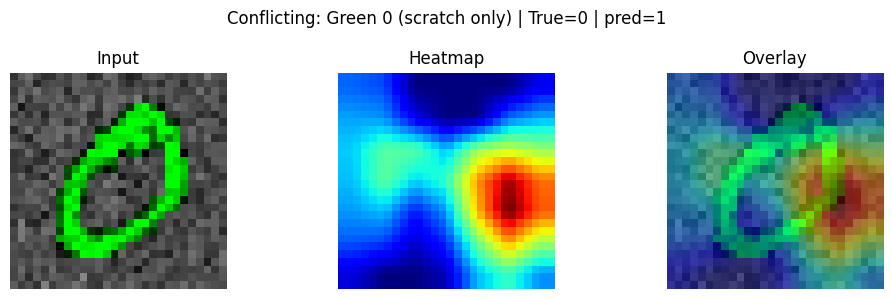

In [29]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class GradCAMScratch:
    """
    Grad-CAM from scratch (robust):
      A = activations at target layer: [B,C,h,w]
      G = d(score)/dA                 : [B,C,h,w]
      alpha_k = mean_{i,j} G_k(i,j)   : [C]
      CAM = ReLU(sum_k alpha_k * A_k) : [h,w] -> upsample to input size
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.h = target_layer.register_forward_hook(self._forward_hook)

    def _forward_hook(self, module, inp, out):
        # out: [B,C,h,w]
        self.activations = out

        # capture gradients wrt this activation tensor
        def _tensor_grad_hook(grad):
            self.gradients = grad
        if out.requires_grad:
            out.register_hook(_tensor_grad_hook)


    def close(self):
        self.h.remove()

    def generate(self, x_norm_bchw, target_class=None):
        """
        x_norm_bchw: normalized input tensor [1,3,H,W] on device
        returns:
          cam_np: [H,W] in [0,1]
          pred: int
          probs_np: [num_classes]
        """
        self.model.eval()

        # IMPORTANT: clear stale stored tensors BEFORE forward
        self.activations = None
        self.gradients = None

        with torch.enable_grad():
            logits = self.model(x_norm_bchw)
            probs = F.softmax(logits, dim=1)
            pred = int(probs.argmax(1).item())

            if target_class is None:
                target_class = pred

            score = logits[0, target_class]
            self.model.zero_grad(set_to_none=True)
            score.backward()

            if self.activations is None or self.gradients is None:
                raise RuntimeError(
                    "Grad-CAM hooks didn't capture activations/gradients.\n"
                    "Common causes: you called .close() and reused engine, or grad disabled globally."
                )

            A = self.activations[0]  # [C,h,w]
            G = self.gradients[0]    # [C,h,w]

            alpha = G.mean(dim=(1, 2))                 # [C]
            cam = (alpha[:, None, None] * A).sum(0)    # [h,w]
            cam = F.relu(cam)

            cam = cam[None, None, :, :]
            cam = F.interpolate(cam, size=x_norm_bchw.shape[-2:], mode="bilinear", align_corners=False)[0, 0]

            cam = cam - cam.min()
            cam = cam / (cam.max() + 1e-8)

        return cam.detach().cpu().numpy(), pred, probs[0].detach().cpu().numpy()

def overlay_cam_on_img(img01_chw, cam2d, alpha=0.45):
    img = img01_chw.detach().cpu().permute(1,2,0).numpy()
    img = np.clip(img, 0, 1)
    heat = plt.cm.jet(cam2d)[:, :, :3]
    out = (1 - alpha) * img + alpha * heat
    return np.clip(out, 0, 1)

def show_cam_row(img01_chw, cam2d, title=""):
    ov = overlay_cam_on_img(img01_chw, cam2d)
    plt.figure(figsize=(10, 3))
    plt.subplot(1,3,1); plt.title("Input");   plt.imshow(img01_chw.permute(1,2,0).cpu()); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Heatmap"); plt.imshow(cam2d, cmap="jet"); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Overlay"); plt.imshow(ov); plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def cam_focus_ratio(cam2d, raw_uint8_hw):
    """
    raw_uint8_hw: torch uint8 [28,28] OR numpy [28,28]
    Returns mean CAM on background vs digit-stroke, plus ratio.
    ratio > 1 => CAM more on background (often "color cheating" here).
    """
    raw = raw_uint8_hw.detach().cpu().numpy() if isinstance(raw_uint8_hw, torch.Tensor) else raw_uint8_hw
    stroke = raw > 0
    bg = ~stroke
    stroke_mean = float(cam2d[stroke].mean()) if stroke.any() else 0.0
    bg_mean = float(cam2d[bg].mean()) if bg.any() else 0.0
    ratio = bg_mean / (stroke_mean + 1e-8)
    return bg_mean, stroke_mean, ratio

def run_case_scratch(name, img01_chw, true_label, raw_hw, cam_engine):
    x_norm = normalize_like_train(img01_chw.unsqueeze(0).to(device))
    cam2d, pred, probs = cam_engine.generate(x_norm, target_class=None)
    bgm, sm, ratio = cam_focus_ratio(cam2d, raw_hw)
    title = f"{name} | True={true_label} | Pred={pred} | P(pred)={probs[pred]:.3f} | bg/stroke={ratio:.2f}"
    show_cam_row(img01_chw, cam2d, title=title)
    print(f"{name}: bg_mean={bgm:.4f}, stroke_mean={sm:.4f}, bg/stroke={ratio:.2f}")

# 3) Optional: pytorch-grad-cam comparison (if installed)
def pytorch_gradcam_generate(model, target_layer, x_norm_bchw, target_class=None):
    try:
        from pytorch_grad_cam import GradCAM as PGGradCAM
        from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
    except Exception as e:
        raise ImportError("pytorch-grad-cam not installed. Install with: pip install grad-cam") from e

    model.eval()
    with torch.no_grad():
        logits = model(x_norm_bchw)
        probs = F.softmax(logits, dim=1)
        pred = int(probs.argmax(1).item())
        if target_class is None:
            target_class = pred

    targets = [ClassifierOutputTarget(target_class)]

    # PGGradCAM returns [B,H,W] numpy
    with PGGradCAM(model=model, target_layers=[target_layer]) as cam:
        grayscale_cam = cam(input_tensor=x_norm_bchw, targets=targets)
        cam2d = grayscale_cam[0]
        cam2d = (cam2d - cam2d.min()) / (cam2d.max() + 1e-8)

    return cam2d, pred, probs[0].detach().cpu().numpy()

def compare_scratch_vs_lib(name, img01_chw, true_label, raw_hw, scratch_engine, lib_layer):
    x_norm = normalize_like_train(img01_chw.unsqueeze(0).to(device))

    cam_s, pred_s, probs_s = scratch_engine.generate(x_norm, target_class=None)
    try:
        cam_l, pred_l, probs_l = pytorch_gradcam_generate(model, lib_layer, x_norm, target_class=None)
        have_lib = True
    except ImportError as e:
        print(f"[skip] {e}")
        have_lib = False

    bgm_s, sm_s, ratio_s = cam_focus_ratio(cam_s, raw_hw)
    ov_s = overlay_cam_on_img(img01_chw, cam_s)

    if have_lib:
        bgm_l, sm_l, ratio_l = cam_focus_ratio(cam_l, raw_hw)
        ov_l = overlay_cam_on_img(img01_chw, cam_l)

        plt.figure(figsize=(12, 6))
        plt.subplot(2,3,1); plt.title("Input"); plt.imshow(img01_chw.permute(1,2,0).cpu()); plt.axis("off")

        plt.subplot(2,3,2); plt.title(f"Scratch heat | bg/stroke={ratio_s:.2f}"); plt.imshow(cam_s, cmap="jet"); plt.axis("off")
        plt.subplot(2,3,3); plt.title(f"Scratch overlay | pred={pred_s}"); plt.imshow(ov_s); plt.axis("off")

        plt.subplot(2,3,5); plt.title(f"Lib heat | bg/stroke={ratio_l:.2f}"); plt.imshow(cam_l, cmap="jet"); plt.axis("off")
        plt.subplot(2,3,6); plt.title(f"Lib overlay | pred={pred_l}"); plt.imshow(ov_l); plt.axis("off")

        plt.suptitle(f"{name} | True={true_label}")
        plt.tight_layout()
        plt.show()
    else:
        show_cam_row(img01_chw, cam_s, title=f"{name} (scratch only) | True={true_label} | pred={pred_s}")

TARGET_LAYER = model.conv3  #
scratch_engine = GradCAMScratch(model, TARGET_LAYER)

DIGIT = 0  
run_case_scratch("Biased: Red 0", biased01, true_label=DIGIT, raw_hw=raw0, cam_engine=scratch_engine)
run_case_scratch("Conflicting: Green 0", conf01, true_label=DIGIT, raw_hw=raw0, cam_engine=scratch_engine)

compare_scratch_vs_lib("Biased: Red 0", biased01, DIGIT, raw0, scratch_engine, lib_layer=TARGET_LAYER)
compare_scratch_vs_lib("Conflicting: Green 0", conf01, DIGIT, raw0, scratch_engine, lib_layer=TARGET_LAYER)

scratch_engine.close()

---

## Task 4: The Intervention - Training Robust Models

In [30]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class _GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambd: float):
        ctx.lambd = lambd
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_out):
        return -ctx.lambd * grad_out, None

def grad_reverse(x, lambd=1.0):
    return _GradReverse.apply(x, float(lambd))

class DANNColorInvariant(nn.Module):
    def __init__(self, backbone: nn.Module, feat_dim=128, num_colors=2):
        super().__init__()
        self.backbone = backbone
        self.features = nn.Sequential(
            backbone.conv1, backbone.relu1, backbone.pool1,
            backbone.conv2, backbone.relu2, backbone.pool2,
            backbone.conv3, backbone.relu3
        )
        self.gap = backbone.gap
        self.digit_head = backbone.fc
        self.color_head = nn.Sequential(
            nn.Linear(feat_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_colors),
        )

    def _feats(self, x):
        h = self.features(x)
        f = self.gap(h).flatten(1)
        return f

    def forward(self, x):
        f = self._feats(x)
        return self.digit_head(f)

    def forward_with_color(self, x, grl_lambda=1.0):
        f = self._feats(x)
        digit_logits = self.digit_head(f)
        nuisance_logits = self.color_head(grad_reverse(f, grl_lambda))
        return digit_logits, nuisance_logits

def train_epoch_dann_twostep(model, loader, opt, epoch, lambda_color_max=2.0, k_color_steps=3):
    model.train()
    correct = total = 0

    grl_l = 1.0
    lambda_color = lambda_color_max if epoch <= 5 else 0.2
    dom_weights = torch.tensor([30.0, 1.0], device=device)

    for x, y, c, _ in loader:
        x = x.to(device)
        y = y.to(device)
        c = c.to(device)

        dom = (c == y).long()

        for _ in range(k_color_steps):
            opt.zero_grad(set_to_none=True)
            f_det = model._feats(x).detach()
            dom_logits_det = model.color_head(f_det)
            loss_dom_det = F.cross_entropy(dom_logits_det, dom, weight=dom_weights)
            loss_dom_det.backward()
            opt.step()

        opt.zero_grad(set_to_none=True)
        digit_logits, dom_logits = model.forward_with_color(x, grl_lambda=grl_l)

        loss_digit = F.cross_entropy(digit_logits, y)
        loss_dom   = F.cross_entropy(dom_logits, dom, weight=dom_weights)

        loss = loss_digit + lambda_color * loss_dom
        loss.backward()
        opt.step()

        pred = digit_logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return correct / total


In [31]:
EPOCHS_TASK4 = 15

backbone = Simple3LayerCNN().to(device)
model_dann = DANNColorInvariant(backbone, feat_dim=128, num_colors=2).to(device)

opt = torch.optim.Adam([
    {"params": model_dann.features.parameters(),   "lr": 1e-3},
    {"params": model_dann.gap.parameters(),        "lr": 1e-3},
    {"params": model_dann.digit_head.parameters(), "lr": 1e-3},
    {"params": model_dann.color_head.parameters(), "lr": 1e-2},
])

TASK4_NUM = 4
TASK4_DANN = "task4_dann_twostep"
task4_dir = get_task_dir(TASK4_NUM)
metrics_path = task4_dir / "metrics_dann_twostep.csv"

start_epoch, extra = load_checkpoint(TASK4_DANN, model_dann, opt, extra_keys=("best_hard",), task_num=TASK4_NUM)
best_hard = float(extra.get("best_hard", -1.0) if extra.get("best_hard", None) is not None else -1.0)

for e in range(start_epoch, EPOCHS_TASK4):
    epoch_num = e + 1
    tr = train_epoch_dann_twostep(
        model_dann,
        easy_train_loader,
        opt,
        epoch=epoch_num,
        lambda_color_max=2.0,
        k_color_steps=3
    )
    va, _, _ = eval_epoch(model_dann, easy_val_loader)
    ht, _, _ = eval_epoch(model_dann, hard_test_loader)

    append_csv(metrics_path, {
        "epoch": epoch_num,
        "easy_train_acc": tr,
        "easy_val_acc": va,
        "hard_test_acc": ht
    })

    print(f"[DANN-TWOSTEP] Epoch {epoch_num:02d}: EasyTrain={tr:.4f} | EasyVal={va:.4f} | HardTest={ht:.4f}")

    if ht > best_hard:
        best_hard = ht
        save_best(TASK4_DANN, model_dann, opt, task_num=TASK4_NUM, best_hard=best_hard, epoch=e)

    save_checkpoint(TASK4_DANN, e, model_dann, opt, task_num=TASK4_NUM, best_hard=best_hard)

print(f"[Task4-DANN-TWOSTEP] done. best_hard={best_hard:.4f} | metrics={metrics_path}")

[resume] task4_dann_twostep: loaded C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task4\checkpoints\task4_dann_twostep_last.pt -> start_epoch=15
[Task4-DANN-TWOSTEP] done. best_hard=0.7508 | metrics=C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task4\metrics_dann_twostep.csv


In [32]:
import torch
import torch.nn.functional as F

def train_epoch_saliency_chroma_masked(
    model,
    loader,
    opt,
    epoch,
    lambda_sal_max=8e-3,
    clip_grad=1.0,
    device="cuda",
    mask_thresh=0.15
):
    model.train()
    correct = total = 0

    if epoch <= 2:
        lambda_sal = lambda_sal_max
    elif epoch <= 5:
        lambda_sal = lambda_sal_max * 0.7
    else:
        lambda_sal = lambda_sal_max * 0.3

    for x, y, c, _ in loader:
        x = x.to(device)
        y = y.to(device)

        x = x.detach().requires_grad_(True)
        opt.zero_grad(set_to_none=True)

        logits = model(x)
        loss_ce = F.cross_entropy(logits, y)

        score = logits.gather(1, y.view(-1, 1)).sum()
        grads = torch.autograd.grad(score, x, create_graph=True)[0]

        grads_centered = grads - grads.mean(dim=1, keepdim=True)

        # --- shape mask from input ---
        with torch.no_grad():
            shape_mask = (x.abs().mean(dim=1, keepdim=True) > mask_thresh).float()
            bg_mask = 1.0 - shape_mask

        loss_sal = (grads_centered.pow(2) * bg_mask).mean()

        loss = loss_ce + lambda_sal * loss_sal
        loss.backward()

        if clip_grad is not None and clip_grad > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

        opt.step()

        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return correct / total

In [33]:
EPOCHS_TASK4 = 15

model_sal = Simple3LayerCNN().to(device)
opt = torch.optim.Adam(model_sal.parameters(), lr=1e-3)

TASK4_SAL = "task4_sal_chroma_masked"
TASK4_NUM = 4
task4_dir = get_task_dir(TASK4_NUM)
metrics_path = task4_dir / "metrics_sal_chroma_masked.csv"

start_epoch, extra = load_checkpoint(TASK4_SAL, model_sal, opt, extra_keys=("best_hard",), task_num=TASK4_NUM)
best_hard = float(extra.get("best_hard", -1.0) if extra.get("best_hard", None) is not None else -1.0)

for e in range(start_epoch, EPOCHS_TASK4):
    epoch_num = e + 1

    tr = train_epoch_saliency_chroma_masked(
        model=model_sal,
        loader=easy_train_loader,
        opt=opt,
        epoch=epoch_num,
        lambda_sal_max=8e-3,
        clip_grad=1.0,
        device=device
    )

    va, _, _ = eval_epoch(model_sal, easy_val_loader)
    ht, _, _ = eval_epoch(model_sal, hard_test_loader)

    append_csv(metrics_path, {
        "epoch": epoch_num,
        "easy_train_acc": tr,
        "easy_val_acc": va,
        "hard_test_acc": ht
    })

    print(
        f"[SAL-CHROMA-MASKED] Epoch {epoch_num:02d}: "
        f"EasyTrain={tr:.4f} | EasyVal={va:.4f} | HardTest={ht:.4f}"
    )

    if ht > best_hard:
        best_hard = ht
        save_best(TASK4_SAL, model_sal, opt, task_num=TASK4_NUM, best_hard=best_hard, epoch=e)

    save_checkpoint(TASK4_SAL, e, model_sal, opt, task_num=TASK4_NUM, best_hard=best_hard)

print(f"[Task4-SAL-CHROMA-MASKED] done. best_hard={best_hard:.4f} | metrics={metrics_path}")

[resume] task4_sal_chroma_masked: loaded C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task4\checkpoints\task4_sal_chroma_masked_last.pt -> start_epoch=15
[Task4-SAL-CHROMA-MASKED] done. best_hard=0.7785 | metrics=C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task4\metrics_sal_chroma_masked.csv


In [34]:
from PIL import Image
from torchvision import transforms

_norm = transforms.Normalize((0.5,)*3, (0.5,)*3)

def recolor_batch_from_raw(raw_bhw, avoid_color_ids=None):
    """
    raw_bhw: torch uint8 [B,H,W] (your dataset's raw)
    avoid_color_ids: torch long [B] or None; if given, choose a new color != avoid_color_ids[i]
    returns: normalized float tensor [B,3,H,W]
    """
    B = raw_bhw.shape[0]
    out = []

    raw_cpu = raw_bhw.detach().cpu()

    # choose random new colors; force different if avoid is provided
    new_colors = torch.randint(0, 10, (B,), dtype=torch.long)
    if avoid_color_ids is not None:
        avoid_cpu = avoid_color_ids.detach().cpu().long()
        same = (new_colors == avoid_cpu)
        # resample where equal (usually small)
        while same.any():
            new_colors[same] = torch.randint(0, 10, (int(same.sum()),), dtype=torch.long)
            same = (new_colors == avoid_cpu)

    for i in range(B):
        rgb_uint8 = colorize_digit_textured(raw_cpu[i], COLOUR_MAP[int(new_colors[i])])
        t = transforms.ToTensor()(Image.fromarray(rgb_uint8))
        t = _norm(t)
        out.append(t)

    return torch.stack(out, dim=0).to(device)

def sym_kl(logits_a, logits_b):
    logp = F.log_softmax(logits_a, dim=1)
    logq = F.log_softmax(logits_b, dim=1)
    p = logp.exp()
    q = logq.exp()
    return F.kl_div(logp, q, reduction="batchmean") + F.kl_div(logq, p, reduction="batchmean")

def train_epoch_counterfactual_invariance(model, loader, opt, lambda_cf=1.0, lambda_cons=1.0):
    """
    loss = CE(x,y) + lambda_cf*CE(x_cf,y) + lambda_cons*symKL(logits(x), logits(x_cf))
    """
    model.train()
    correct = total = 0

    for x, y, c, raw in loader:
        x = x.to(device)
        y = y.to(device)
        c = c.to(device)
        raw = raw  # keep on CPU for recoloring, function handles device move

        opt.zero_grad(set_to_none=True)

        logits = model(x)

        # counterfactual recolor (same shape, different color)
        x_cf = recolor_batch_from_raw(raw, avoid_color_ids=c)
        logits_cf = model(x_cf)

        loss_main = F.cross_entropy(logits, y)
        loss_cf   = F.cross_entropy(logits_cf, y)
        loss_cons = sym_kl(logits, logits_cf)

        loss = loss_main + lambda_cf * loss_cf + lambda_cons * loss_cons
        loss.backward()
        opt.step()

        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return correct / total

In [35]:
EPOCHS_TASK4 = 15

model_cf = Simple3LayerCNN().to(device)
opt = torch.optim.Adam(model_cf.parameters(), lr=1e-3)

TASK4_CF = "task4_cf_invar"
TASK4_NUM = 4
task4_dir = get_task_dir(TASK4_NUM)
metrics_path = task4_dir / "metrics.json"

start_epoch, extra = load_checkpoint(TASK4_CF, model_cf, opt, extra_keys=("best_hard",), task_num=TASK4_NUM)  # Added task_num
best_hard = float(extra.get("best_hard", -1.0) if extra.get("best_hard", None) is not None else -1.0)

for e in range(start_epoch, EPOCHS_TASK4):
    epoch_num = e + 1
    tr = train_epoch_counterfactual_invariance(model_cf, easy_train_loader, opt, lambda_cf=1.0, lambda_cons=1.0)
    va, _, _ = eval_epoch(model_cf, easy_val_loader)
    ht, _, _ = eval_epoch(model_cf, hard_test_loader)

    append_csv(metrics_path, {
        "epoch": epoch_num,
        "easy_train_acc": tr,
        "easy_val_acc": va,
        "hard_test_acc": ht
    })

    msg = f"[CF-INVAR] Epoch {epoch_num:02d}: EasyTrain={tr:.4f} | EasyVal={va:.4f} | HardTest={ht:.4f}"
    print(msg)

    if ht > best_hard:
        best_hard = ht
        save_best(TASK4_CF, model_cf, opt, task_num=TASK4_NUM, best_hard=best_hard, epoch=e)  # Added task_num

    save_checkpoint(TASK4_CF, e, model_cf, opt, task_num=TASK4_NUM, best_hard=best_hard)  # Added task_num

print(f"[Task4-CF] done. best_hard={best_hard:.4f} | metrics={metrics_path}")

[resume] task4_cf_invar: loaded C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task4\checkpoints\task4_cf_invar_last.pt -> start_epoch=15
[Task4-CF] done. best_hard=0.9679 | metrics=C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task4\metrics.json


In [36]:
# TASK 4 — VISUALIZATIONS (ONLY)
#   (1) Prediction grids (Hard Test): baseline vs robust
#   (2) Counterfactual recolor panels (prediction stability)

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pathlib import Path

from PIL import Image
from torchvision import transforms

# --------- folder ----------
TASK4_NUM = 4
TASK4_VIZ_DIR = get_task_figures_dir(TASK4_NUM) / "viz"
TASK4_VIZ_DIR.mkdir(parents=True, exist_ok=True)

device = device if "device" in globals() else ("cuda" if torch.cuda.is_available() else "cpu")

# --------- normalization helpers ----------
def denorm01(x_bchw):
    return (x_bchw * 0.5 + 0.5).clamp(0, 1)

_norm = transforms.Normalize((0.5,)*3, (0.5,)*3)

# --------- model registry (auto-detect selected Task 4 models) ----------
models = {}
if "model" in globals():
    models["Baseline (biased)"] = model
if "model_dann" in globals():
    models["DANN Twostep"] = model_dann
if "model_cf" in globals():
    models["CF Invar"] = model_cf
if "model_sal" in globals():
    models["Saliency Chroma Masked"] = model_sal

if len(models) == 0:
    raise NameError("No models found (expected model/model_dann/model_cf/model_sal).")

print(f"Found {len(models)} models for visualization: {list(models.keys())}")

for m in models.values():
    m.to(device).eval()

# choose a loader for qualitative hard-test viz
if "hard_test_loader" in globals():
    HARD_LOADER = hard_test_loader
elif "hard_test" in globals():
    from torch.utils.data import DataLoader
    HARD_LOADER = DataLoader(hard_test, batch_size=64, shuffle=True)
else:
    raise NameError("Need hard_test_loader or hard_test dataset for visualization.")

# --------- utilities ----------
@torch.no_grad()
def predict_logits(model, x_bchw):
    model.eval()
    logits = model(x_bchw.to(device))
    return logits.detach()  

def get_one_batch(loader, n=10):
    for batch in loader:
        # expected: (x,y,c,raw)
        x, y, c, raw = batch
        return x[:n], y[:n], c[:n], raw[:n]
    raise RuntimeError("Empty loader?")

def save_hardtest_prediction_sheet(models_dict, loader, n=10, out_path=None):
    x, y, c, _ = get_one_batch(loader, n=n)

    n_models = len(models_dict)
    fig, axes = plt.subplots(n, n_models, figsize=(3.0*n_models, 2.7*n))
    if n == 1:
        axes = np.expand_dims(axes, 0)
    if n_models == 1:
        axes = np.expand_dims(axes, 1)

    preds = {}
    for name, m in models_dict.items():
        logits = predict_logits(m, x)
        pred = logits.argmax(1).detach().cpu()
        conf = F.softmax(logits, dim=1).max(1).values.detach().cpu()
        preds[name] = (pred, conf)

    x_vis = denorm01(x).detach().cpu().permute(0, 2, 3, 1).numpy()  # [n,H,W,3]

    col_names = list(models_dict.keys())
    for j, name in enumerate(col_names):
        axes[0, j].set_title(name, fontsize=12)

    for i in range(n):
        for j, name in enumerate(col_names):
            ax = axes[i, j]
            ax.imshow(x_vis[i])
            p, conf = preds[name]
            ok = (int(p[i]) == int(y[i]))
            ax.set_axis_off()
            ax.text(
                0.5, -0.12,
                f"y={int(y[i])}  pred={int(p[i])}  conf={float(conf[i]):.2f}  {'OK' if ok else 'WRONG'}\ncolor_id={int(c[i])}",
                transform=ax.transAxes,
                ha="center", va="top",
                fontsize=9
            )

    plt.tight_layout()
    if out_path is None:
        out_path = TASK4_VIZ_DIR / "hardtest_predictions__models_compare.png"
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close(fig)
    print("Saved:", out_path)

save_hardtest_prediction_sheet(models, HARD_LOADER, n=10)

if "COLOUR_MAP" not in globals() or "colorize_digit_textured" not in globals():
    print("WARNING: COLOUR_MAP/colorize_digit_textured not found. Counterfactual panel will be skipped.")

def recolor_batch_to_color_ids(raw_bhw_uint8, color_ids):
    """
    raw_bhw_uint8: [B,H,W] uint8 (CPU or GPU ok)
    color_ids: torch long [B] values 0..9
    returns: normalized float tensor [B,3,H,W] on device
    """
    raw_cpu = raw_bhw_uint8.detach().cpu()
    color_ids_cpu = color_ids.detach().cpu().long()

    out = []
    for i in range(raw_cpu.shape[0]):
        rgb_uint8 = colorize_digit_textured(raw_cpu[i], COLOUR_MAP[int(color_ids_cpu[i])])
        t = transforms.ToTensor()(Image.fromarray(rgb_uint8))
        t = _norm(t)
        out.append(t)
    return torch.stack(out, dim=0).to(device)

@torch.no_grad()
def save_counterfactual_recolor_sheet(models_dict, loader, n_examples=6, color_choices=(0,1,2,3,4), out_path=None):
    _, y, c, raw = get_one_batch(loader, n=n_examples)
    B = raw.shape[0]
    K = len(color_choices)

    # build recolored batches for each chosen color
    recolored_batches = []
    for col in color_choices:
        color_ids = torch.full((B,), int(col), dtype=torch.long)
        xb = recolor_batch_to_color_ids(raw, color_ids)
        recolored_batches.append(xb)

    # predict for each model, for each recolor
    preds = {name: [] for name in models_dict.keys()}
    confs = {name: [] for name in models_dict.keys()}

    for name, m in models_dict.items():
        for xb in recolored_batches:
            logits = predict_logits(m, xb)
            preds[name].append(logits.argmax(1).detach().cpu())  # [B]
            confs[name].append(F.softmax(logits, dim=1).max(1).values.detach().cpu())

    # plot: rows=examples, cols=recolors; each cell has image + per-model preds
    fig, axes = plt.subplots(n_examples, K, figsize=(3.0*K, 2.8*n_examples))
    if n_examples == 1:
        axes = np.expand_dims(axes, 0)
    if K == 1:
        axes = np.expand_dims(axes, 1)

    for j, col in enumerate(color_choices):
        axes[0, j].set_title(f"recolor color_id={col}", fontsize=12)

    for i in range(n_examples):
        for j, _col in enumerate(color_choices):
            ax = axes[i, j]
            img = denorm01(recolored_batches[j][i:i+1]).detach().cpu()[0].permute(1,2,0).numpy()
            ax.imshow(img)
            ax.set_axis_off()

            lines = [f"y={int(y[i])} (orig color_id={int(c[i])})"]
            for name in models_dict.keys():
                p = int(preds[name][j][i])
                cf = float(confs[name][j][i])
                lines.append(f"{name}: {p} ({cf:.2f})")

            ax.text(
                0.5, -0.10, "\n".join(lines),
                transform=ax.transAxes,
                ha="center", va="top",
                fontsize=8
            )

    plt.tight_layout()
    if out_path is None:
        out_path = TASK4_VIZ_DIR / "counterfactual_recolor__prediction_stability.png"
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close(fig)
    print("Saved:", out_path)

if "COLOUR_MAP" in globals() and "colorize_digit_textured" in globals():
    save_counterfactual_recolor_sheet(models, HARD_LOADER, n_examples=6, color_choices=(0,1,2,3,4))

print("\nTask4 viz saved in:", TASK4_VIZ_DIR)

Found 4 models for visualization: ['Baseline (biased)', 'DANN Twostep', 'CF Invar', 'Saliency Chroma Masked']
Saved: C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task4\figures\viz\hardtest_predictions__models_compare.png
Saved: C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task4\figures\viz\counterfactual_recolor__prediction_stability.png

Task4 viz saved in: C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task4\figures\viz


---

## Task 5: The Invisible Cloak - Adversarial Attacks

In [37]:
# ---- make sure no Grad-CAM hooks are still attached ----
for name in ["scratch_engine", "cam_engine", "gradcam_engine"]:
    if name in globals():
        try:
            globals()[name].close()
            print(f"Closed {name}")
        except Exception as e:
            print(f"Could not close {name}: {e}")

Closed scratch_engine


In [38]:
import sys
!{sys.executable} -m pip install pandas


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
import os, time, json, csv, math, random
from pathlib import Path
from contextlib import contextmanager

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

SOURCE_DIGIT = 7
TARGET_DIGIT = 3
CONF_GOAL    = 0.90

EPS_MAX_PIXEL   = 0.05      # L_inf bound in pixel space [0,1]
COARSE_STEP     = 0.005     # coarse sweep step in pixel space
REFINE_ITERS    = 7         # binary refine steps after first hit

PGD_STEPS       = 120      
RESTARTS        = 10       

N_SHARED_SAMPLES   = 20     # number of shared-correct source samples to evaluate
MAX_BATCHES_SEARCH = 200    # how far to scan the loader to find shared-correct samples

SEED = 0

# -------------------------
# Repro + device
# -------------------------
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = device if "device" in globals() else ("cuda" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(True)

# -------------------------
# Output dirs (resume uses same folder)
# -------------------------
TASK5_NUM = 5
TASK5_DIR = get_task_dir(TASK5_NUM)
TASK5_DIR.mkdir(parents=True, exist_ok=True)

SAMPLES_PT = TASK5_DIR / "samples_shared_correct.pt"
CONFIG_JSON = TASK5_DIR / "run_config.json"
RESULTS_CSV = TASK5_DIR / "task5_results_per_sample.csv"
SUMMARY_CSV = TASK5_DIR / "task5_summary.csv"

PANELS_DIR = TASK5_DIR / "panels"
PANELS_DIR.mkdir(parents=True, exist_ok=True)

PLOTS_DIR = TASK5_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# --------- model registry (match Task 4 models) ----------
models = {}
if "model" in globals():       models["Baseline (biased)"] = globals()["model"]
if "model_dann" in globals():  models["DANN Twostep"] = globals()["model_dann"]
if "model_cf" in globals():    models["CF Invar"] = globals()["model_cf"]
if "model_sal" in globals():   models["Saliency Chroma Masked"] = globals()["model_sal"]

if "Baseline (biased)" not in models:
    raise RuntimeError("Expected baseline model in globals() as `model` (stored as 'Baseline (biased)').")

for m in models.values():
    m.to(device).eval()

print("[Task5] Models:", list(models.keys()))

def _make_loader_from_dataset(ds, batch_size=256):
    from torch.utils.data import DataLoader
    return DataLoader(ds, batch_size=batch_size, shuffle=False)

loader_name = None
if "hard_test_loader" in globals():
    LOADER = globals()["hard_test_loader"]
    loader_name = "hard_test_loader"
elif "hard_test" in globals():
    LOADER = _make_loader_from_dataset(globals()["hard_test"])
    loader_name = "hard_test"
elif "easy_val_loader" in globals():
    LOADER = globals()["easy_val_loader"]
    loader_name = "easy_val_loader"
elif "easy_val" in globals():
    LOADER = _make_loader_from_dataset(globals()["easy_val"])
    loader_name = "easy_val"
else:
    raise RuntimeError("Need one of: hard_test_loader, hard_test, easy_val_loader, easy_val.")

print(f"[Task5] Using loader: {loader_name}")

def denorm01(x_bchw):
    # from [-1,1] -> [0,1]
    return (x_bchw * 0.5 + 0.5).clamp(0, 1)

def clamp_norm(x_norm):
    return x_norm.clamp(-1.0, 1.0)

def pixel_eps_to_norm_eps(eps_pixel: float) -> float:
    # x_norm = (x - 0.5)/0.5 => delta_norm = delta_pixel / 0.5
    return float(eps_pixel) / 0.5

def norm_delta_to_pixel_linf(delta_norm: torch.Tensor) -> float:
    # delta_pixel = delta_norm * std = delta_norm * 0.5
    return float(delta_norm.detach().abs().max().item() * 0.5)

def forward_logits(model, x_bchw):
    model.eval()
    x_bchw = x_bchw.to(device)
    if not x_bchw.requires_grad:
        x_bchw = x_bchw.detach().clone().requires_grad_(True)
    return model(x_bchw)

def pred_and_confs(model, x_bchw, target=None):
    logits = forward_logits(model, x_bchw)
    probs = F.softmax(logits, dim=1)
    pred = int(probs.argmax(1).detach().cpu().item())
    conf_max = float(probs.max(1).values.detach().cpu().item())
    conf_t = None
    if target is not None:
        conf_t = float(probs[0, int(target)].detach().cpu().item())
    return pred, conf_max, conf_t

@contextmanager
def freeze_model_params(model):
    old = [p.requires_grad for p in model.parameters()]
    try:
        for p in model.parameters():
            p.requires_grad_(False)
        yield
    finally:
        for p, rg in zip(model.parameters(), old):
            p.requires_grad_(rg)

def targeted_pgd_best(
    model,
    x0_1chw,
    y_target: int,
    eps_pixel: float,
    steps: int,
    restarts: int,
    conf_goal: float
):
    """
    Returns dict with best result at this eps:
      success, x_adv, delta_norm, pred, conf_max, conf_t
    best is chosen by max conf_t (target confidence).
    """
    eps_norm = pixel_eps_to_norm_eps(eps_pixel)
    # step size: a practical default
    alpha = eps_norm / max(steps // 5, 1)

    x0 = x0_1chw.detach().to(device)
    y_t = torch.tensor([int(y_target)], device=device, dtype=torch.long)

    best = None
    best_conf_t = -1.0

    for r in range(int(restarts)):
        if r == 0:
            delta = torch.zeros_like(x0, device=device)
        else:
            delta = torch.empty_like(x0).uniform_(-eps_norm, eps_norm).to(device)

        for _ in range(int(steps)):
            delta.requires_grad_(True)
            x_adv = clamp_norm(x0 + delta)

            logits = forward_logits(model, x_adv)
            loss = F.cross_entropy(logits, y_t)   

            grad = torch.autograd.grad(loss, delta, retain_graph=False, create_graph=False)[0]
            delta = (delta - alpha * grad.sign()).detach()
            delta = delta.clamp(-eps_norm, eps_norm)

            pred, conf_max, conf_t = pred_and_confs(model, clamp_norm(x0 + delta), target=y_target)
            if conf_t is not None and conf_t >= conf_goal and pred == int(y_target):
                x_adv_fin = clamp_norm(x0 + delta).detach()
                out = dict(
                    success=True,
                    x_adv=x_adv_fin,
                    delta_norm=delta.detach(),
                    pred=pred,
                    conf_max=conf_max,
                    conf_t=conf_t
                )
                if conf_t > best_conf_t:
                    best, best_conf_t = out, conf_t
                break

        pred, conf_max, conf_t = pred_and_confs(model, clamp_norm(x0 + delta), target=y_target)
        out = dict(
            success=(pred == int(y_target) and conf_t is not None and conf_t >= conf_goal),
            x_adv=clamp_norm(x0 + delta).detach(),
            delta_norm=delta.detach(),
            pred=pred,
            conf_max=conf_max,
            conf_t=float(conf_t) if conf_t is not None else None
        )
        if out["conf_t"] is not None and out["conf_t"] > best_conf_t:
            best, best_conf_t = out, out["conf_t"]

        # optional: if already strong success, no need for more restarts
        if best is not None and best["success"]:
            break

    return best

def find_min_eps(
    model,
    x0_1chw,
    y_target: int,
    eps_max_pixel: float,
    coarse_step: float,
    refine_iters: int,
    steps: int,
    restarts: int,
    conf_goal: float
):
    """
    Coarse sweep -> binary refine.
    Returns:
      eps_min_pixel (or None), best_at_eps_min (dict), best_at_eps_max (dict)
    """
    # always compute best@eps_max for "if fail, report best target conf at eps=0.05"
    best_at_eps_max = targeted_pgd_best(model, x0_1chw, y_target, eps_max_pixel, steps, restarts, conf_goal)

    # coarse sweep for first success
    grid = np.arange(0.0, eps_max_pixel + 1e-12, coarse_step).tolist()

    first_hit = None
    first_pack = None
    prev_eps = 0.0

    for eps in grid:
        pack = targeted_pgd_best(model, x0_1chw, y_target, float(eps), steps, restarts, conf_goal)
        if pack is not None and pack["success"]:
            first_hit = float(eps)
            first_pack = pack
            break
        prev_eps = float(eps)

    if first_hit is None:
        return None, None, best_at_eps_max

    # binary refine in [max(0, first_hit - coarse_step), first_hit]
    lo = max(0.0, first_hit - coarse_step)
    hi = first_hit
    best_eps = first_hit
    best_pack = first_pack

    for _ in range(int(refine_iters)):
        mid = (lo + hi) / 2.0
        pack = targeted_pgd_best(model, x0_1chw, y_target, float(mid), steps, restarts, conf_goal)
        if pack is not None and pack["success"]:
            hi = mid
            best_eps = mid
            best_pack = pack
        else:
            lo = mid

    return float(best_eps), best_pack, best_at_eps_max

def collect_shared_correct_samples(loader, models_dict, digit: int, n: int, max_batches: int):
    xs, ys, cs = [], [], []
    checked_batches = 0

    # freeze all params during scanning (faster)
    frozen = [freeze_model_params(m) for m in models_dict.values()]
    for ctx in frozen: ctx.__enter__()
    try:
        for (x, y, c, raw) in loader:
            x = x.to(device)
            y = y.to(device)
            c = c.to(device)

            idxs = (y == digit).nonzero(as_tuple=False).flatten()
            if idxs.numel() == 0:
                checked_batches += 1
                if checked_batches >= max_batches: break
                continue

            for ii in idxs.tolist():
                x0 = x[ii:ii+1]  # 1x3xHxW
                ok = True
                for name, m in models_dict.items():
                    pred, conf_max, _ = pred_and_confs(m, x0, target=None)
                    if pred != digit:
                        ok = False
                        break
                if ok:
                    xs.append(x0.detach().cpu())
                    ys.append(int(digit))
                    cs.append(int(c[ii].detach().cpu().item()))
                    if len(xs) >= n:
                        return xs, ys, cs

            checked_batches += 1
            if checked_batches >= max_batches:
                break
    finally:
        for ctx in reversed(frozen):
            ctx.__exit__(None, None, None)

    return xs, ys, cs

if SAMPLES_PT.exists():
    payload = torch.load(SAMPLES_PT, map_location="cpu")
    x_list = payload["x_list"]
    y_list = payload["y_list"]
    c_list = payload["c_list"]
    sample_source = payload.get("sample_source", "unknown")
    print(f"[Task5] Loaded saved samples: {len(x_list)} (source={sample_source})")
else:
    print("[Task5] Collecting shared-correct samples...")
    x_list, y_list, c_list = collect_shared_correct_samples(
        LOADER, models, digit=SOURCE_DIGIT, n=N_SHARED_SAMPLES, max_batches=MAX_BATCHES_SEARCH
    )
    if len(x_list) < max(5, N_SHARED_SAMPLES // 2):
        print(f"[Task5] Warning: only found {len(x_list)} shared-correct samples in {loader_name}.")
        print("[Task5] Tip: If baseline is weak on hard_test, try running Task5 on easy_val instead for fair attack difficulty.")
    sample_source = loader_name
    torch.save(
        {"x_list": x_list, "y_list": y_list, "c_list": c_list, "sample_source": sample_source},
        SAMPLES_PT
    )
    print(f"[Task5] Saved samples to: {SAMPLES_PT} (n={len(x_list)})")

# Save config once (paper reproducibility)
if not CONFIG_JSON.exists():
    cfg = dict(
        source_digit=SOURCE_DIGIT, target_digit=TARGET_DIGIT, conf_goal=CONF_GOAL,
        eps_max_pixel=EPS_MAX_PIXEL, coarse_step=COARSE_STEP, refine_iters=REFINE_ITERS,
        pgd_steps=PGD_STEPS, restarts=RESTARTS, n_shared_samples=N_SHARED_SAMPLES,
        loader_used=loader_name, seed=SEED, models=list(models.keys())
    )
    with open(CONFIG_JSON, "w") as f:
        json.dump(cfg, f, indent=2)
    print(f"[Task5] Wrote config: {CONFIG_JSON}")

def load_done_keys(csv_path: Path):
    done = set()
    if not csv_path.exists():
        return done
    with open(csv_path, "r", newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            done.add((int(row["sample_idx"]), row["model"]))
    return done

def append_row(csv_path: Path, fieldnames, rowdict):
    file_exists = csv_path.exists()
    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()
        writer.writerow(rowdict)

DONE = load_done_keys(RESULTS_CSV)
print(f"[Task5] Resume: {len(DONE)} (sample,model) already computed.")

fieldnames = [
    "sample_idx","model","sample_source","color_id",
    "source_digit","target_digit","conf_goal",
    "eps_max_pixel","pgd_steps","restarts",
    "eps_min_pixel","success_within_epsmax",
    "pred_at_epsmin","conf_target_at_epsmin","conf_max_at_epsmin",
    "delta_linf_pixel_at_epsmin",
    "best_pred_at_epsmax","best_conf_target_at_epsmax","best_conf_max_at_epsmax",
    "best_delta_linf_pixel_at_epsmax",
    "elapsed_sec"
]

x_cpu = x_list
c_ids = c_list

# move samples to GPU/CPU only when needed
for si in range(len(x_cpu)):
    x0 = x_cpu[si].to(device)
    c0 = int(c_ids[si])

    for model_name, m in models.items():
        key = (si, model_name)
        if key in DONE:
            continue

        t0 = time.time()
        with freeze_model_params(m):
            eps_min, pack_min, pack_epsmax = find_min_eps(
                m, x0, y_target=TARGET_DIGIT,
                eps_max_pixel=EPS_MAX_PIXEL,
                coarse_step=COARSE_STEP,
                refine_iters=REFINE_ITERS,
                steps=PGD_STEPS,
                restarts=RESTARTS,
                conf_goal=CONF_GOAL
            )
        elapsed = time.time() - t0

        # eps_max pack
        if pack_epsmax is None:
            # should not happen, but safe fallback
            pack_epsmax = dict(success=False, x_adv=x0.detach(), delta_norm=torch.zeros_like(x0), pred=None, conf_max=None, conf_t=None)

        best_delta_linf_pix = norm_delta_to_pixel_linf(pack_epsmax["delta_norm"]) if pack_epsmax.get("delta_norm") is not None else None

        if eps_min is None or pack_min is None:
            row = dict(
                sample_idx=si, model=model_name, sample_source=sample_source, color_id=c0,
                source_digit=SOURCE_DIGIT, target_digit=TARGET_DIGIT, conf_goal=CONF_GOAL,
                eps_max_pixel=EPS_MAX_PIXEL, pgd_steps=PGD_STEPS, restarts=RESTARTS,
                eps_min_pixel="",
                success_within_epsmax=0,
                pred_at_epsmin="",
                conf_target_at_epsmin="",
                conf_max_at_epsmin="",
                delta_linf_pixel_at_epsmin="",
                best_pred_at_epsmax=pack_epsmax["pred"],
                best_conf_target_at_epsmax=pack_epsmax["conf_t"],
                best_conf_max_at_epsmax=pack_epsmax["conf_max"],
                best_delta_linf_pixel_at_epsmax=best_delta_linf_pix,
                elapsed_sec=round(elapsed, 4)
            )
        else:
            dlinf_pix = norm_delta_to_pixel_linf(pack_min["delta_norm"])
            row = dict(
                sample_idx=si, model=model_name, sample_source=sample_source, color_id=c0,
                source_digit=SOURCE_DIGIT, target_digit=TARGET_DIGIT, conf_goal=CONF_GOAL,
                eps_max_pixel=EPS_MAX_PIXEL, pgd_steps=PGD_STEPS, restarts=RESTARTS,
                eps_min_pixel=float(eps_min),
                success_within_epsmax=1,
                pred_at_epsmin=pack_min["pred"],
                conf_target_at_epsmin=pack_min["conf_t"],
                conf_max_at_epsmin=pack_min["conf_max"],
                delta_linf_pixel_at_epsmin=dlinf_pix,
                best_pred_at_epsmax=pack_epsmax["pred"],
                best_conf_target_at_epsmax=pack_epsmax["conf_t"],
                best_conf_max_at_epsmax=pack_epsmax["conf_max"],
                best_delta_linf_pixel_at_epsmax=best_delta_linf_pix,
                elapsed_sec=round(elapsed, 4)
            )

        append_row(RESULTS_CSV, fieldnames, row)
        DONE.add(key)
        print(f"[Task5] saved: sample={si:02d} model={model_name:16s} "
              f"eps_min={row['eps_min_pixel'] if row['eps_min_pixel']!='' else 'None'} "
              f"best@0.05 conf_t={row['best_conf_target_at_epsmax']}")

print(f"\n[Task5] Done. Results CSV: {RESULTS_CSV}")

def load_rows(csv_path: Path):
    rows = []
    with open(csv_path, "r", newline="") as f:
        reader = csv.DictReader(f)
        for r in reader:
            # coerce numeric fields where possible
            r2 = dict(r)
            r2["sample_idx"] = int(r2["sample_idx"])
            r2["color_id"] = int(r2["color_id"])
            r2["success_within_epsmax"] = int(r2["success_within_epsmax"])
            for k in ["eps_min_pixel","conf_target_at_epsmin","conf_max_at_epsmin",
                      "delta_linf_pixel_at_epsmin","best_conf_target_at_epsmax",
                      "best_conf_max_at_epsmax","best_delta_linf_pixel_at_epsmax","elapsed_sec"]:
                if r2.get(k, "") == "" or r2.get(k, None) is None:
                    r2[k] = None
                else:
                    r2[k] = float(r2[k])
            # ints that may be blank
            for k in ["pred_at_epsmin","best_pred_at_epsmax"]:
                if r2.get(k, "") == "" or r2.get(k, None) is None:
                    r2[k] = None
                else:
                    r2[k] = int(float(r2[k]))
            rows.append(r2)
    return rows

rows = load_rows(RESULTS_CSV)

# summary stats per model
def median_or_none(vals):
    vv = [v for v in vals if v is not None]
    if len(vv) == 0:
        return None
    return float(np.median(np.array(vv, dtype=np.float32)))

def mean_or_none(vals):
    vv = [v for v in vals if v is not None]
    if len(vv) == 0:
        return None
    return float(np.mean(np.array(vv, dtype=np.float32)))

models_list = list(models.keys())

summary = []
for mn in models_list:
    rr = [r for r in rows if r["model"] == mn]
    eps_succ = [r["eps_min_pixel"] for r in rr if r["success_within_epsmax"] == 1]
    succ_rate = (sum(r["success_within_epsmax"] for r in rr) / max(len(rr), 1)) if len(rr) > 0 else 0.0
    best_conf_at_max = mean_or_none([r["best_conf_target_at_epsmax"] for r in rr])

    summary.append(dict(
        model=mn,
        n=len(rr),
        success_rate=succ_rate,
        median_eps=median_or_none(eps_succ),
        mean_eps=mean_or_none(eps_succ),
        mean_best_conf_at_epsmax=best_conf_at_max
    ))

with open(SUMMARY_CSV, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=list(summary[0].keys()))
    writer.writeheader()
    writer.writerows(summary)

print(f"[Task5] Summary CSV: {SUMMARY_CSV}")
for s in summary:
    print(f"  {s['model']:20s}  success={100*s['success_rate']:.1f}%  "
          f"median_eps={s['median_eps']}  mean_eps={s['mean_eps']}  mean_best_conf@0.05={s['mean_best_conf_at_epsmax']}")

# baseline ratios (paper-friendly)
base = next((s for s in summary if s["model"] == "Baseline (biased)"), summary[0])
base_med = base["median_eps"]
print("\n[Task5] Median eps ratios vs baseline (only if both medians exist):")
for s in summary:
    if s["model"] == base["model"]:
        continue
    if base_med is not None and s["median_eps"] is not None and base_med > 0:
        print(f"  {s['model']:20s}  ratio={s['median_eps']/base_med:.2f}x")
    else:
        print(f"  {s['model']:20s}  ratio=N/A")

names = [s["model"] for s in summary]
meds  = [s["median_eps"] if s["median_eps"] is not None else np.nan for s in summary]
succ  = [s["success_rate"] for s in summary]

plt.figure(figsize=(10,4))
xpos = np.arange(len(names))
plt.bar(xpos, meds)
plt.xticks(xpos, names, rotation=25, ha="right")
plt.ylabel("Median min ε (pixel L∞) for 7→3, conf≥0.90")
plt.title("Task 5: Targeted Attack Difficulty (higher = harder to fool)")
for i, sr in enumerate(succ):
    y = meds[i] if np.isfinite(meds[i]) else 0.0
    plt.text(i, y + 0.001, f"{sr*100:.0f}%", ha="center", va="bottom", fontsize=9)
bar_path = PLOTS_DIR / "median_eps_bar.png"
plt.tight_layout()
plt.savefig(bar_path, dpi=220, bbox_inches="tight")
plt.close()
print(f"[Task5] Saved plot: {bar_path}")

eps_grid = np.linspace(0.0, EPS_MAX_PIXEL, 26)
plt.figure(figsize=(10,4))
for mn in names:
    rr = [r for r in rows if r["model"] == mn]
    eps_mins = [r["eps_min_pixel"] for r in rr]
    frac = []
    for e in eps_grid:
        ok = 0
        total = 0
        for v in eps_mins:
            total += 1
            if v is not None and v <= e:
                ok += 1
        frac.append(ok / max(total,1))
    plt.plot(eps_grid, frac, marker="o", linewidth=2, label=mn)
plt.ylim([-0.02, 1.02])
plt.xlabel("ε (pixel L∞ bound)")
plt.ylabel("Fraction successful (target conf≥0.90)")
plt.title("Task 5: Success rate vs ε (derived from min-ε per sample)")
plt.grid(True, alpha=0.25)
plt.legend()
curve_path = PLOTS_DIR / "success_vs_epsilon_curve.png"
plt.tight_layout()
plt.savefig(curve_path, dpi=220, bbox_inches="tight")
plt.close()
print(f"[Task5] Saved plot: {curve_path}")

def save_panel(x0, x_adv, delta_norm, title, out_path):
    x0v  = denorm01(x0).detach().cpu()[0].permute(1,2,0).numpy()
    xav  = denorm01(x_adv).detach().cpu()[0].permute(1,2,0).numpy()

    d = delta_norm.detach().cpu()[0]
    # mean abs δ in norm space
    d_mag = d.abs().mean(dim=0).numpy()
    d_mag = (d_mag - d_mag.min()) / (d_mag.max() - d_mag.min() + 1e-8)

    # amplified δ in pixel space for visibility
    d_pix = (d * 0.5).clamp(-EPS_MAX_PIXEL, EPS_MAX_PIXEL)  # norm -> pixel
    amp = 10.0
    d_rgb = (0.5 + amp * d_pix.permute(1,2,0)).clamp(0,1).numpy()

    fig, axes = plt.subplots(1,4, figsize=(13,3))
    axes[0].imshow(x0v);   axes[0].set_title("Original"); axes[0].axis("off")
    axes[1].imshow(xav);   axes[1].set_title("Adversarial"); axes[1].axis("off")
    axes[2].imshow(d_mag, cmap="gray"); axes[2].set_title("mean|δ| (norm)"); axes[2].axis("off")
    axes[3].imshow(d_rgb); axes[3].set_title("δ (pixel) ×10"); axes[3].axis("off")
    fig.suptitle(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=220, bbox_inches="tight")
    plt.close(fig)

rows_by_model = {mn: [] for mn in names}
for r in rows:
    rows_by_model[r["model"]].append(r)
for mn in names:
    rows_by_model[mn].sort(key=lambda r: (1e9 if r["eps_min_pixel"] is None else r["eps_min_pixel"]))

# regenerate best example at eps_min or eps_max (so we can save images)
for mn, m in models.items():
    rr = rows_by_model[mn]
    if len(rr) == 0:
        continue
    # choose first success else first row (fail)
    chosen = next((r for r in rr if r["success_within_epsmax"] == 1), rr[0])
    si = chosen["sample_idx"]
    x0 = x_cpu[si].to(device)

    with freeze_model_params(m):
        if chosen["success_within_epsmax"] == 1:
            eps_use = float(chosen["eps_min_pixel"])
        else:
            eps_use = EPS_MAX_PIXEL

        pack = targeted_pgd_best(m, x0, TARGET_DIGIT, eps_use, PGD_STEPS, RESTARTS, CONF_GOAL)

    title = (
        f"{mn} | sample={si} | 7→3 | "
        f"eps={'min' if chosen['success_within_epsmax']==1 else '0.05'}={eps_use:.4f} | "
        f"pred={pack['pred']} | conf_t={pack['conf_t']:.3f}"
    )
    out_path = PANELS_DIR / f"panel_{mn.replace(' ','_')}_s{si:02d}.png"
    save_panel(x0, pack["x_adv"], pack["delta_norm"], title, out_path)

print(f"\n[Task5] Panels saved in: {PANELS_DIR}")
print(f"[Task5] All outputs in: {TASK5_DIR}")

[Task5] Models: ['Baseline (biased)', 'DANN Twostep', 'CF Invar', 'Saliency Chroma Masked']
[Task5] Using loader: hard_test_loader
[Task5] Loaded saved samples: 20 (source=hard_test_loader)
[Task5] Resume: 80 (sample,model) already computed.

[Task5] Done. Results CSV: C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task5\task5_results_per_sample.csv
[Task5] Summary CSV: C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task5\task5_summary.csv
  Baseline (biased)     success=20.0%  median_eps=0.04337890446186066  mean_eps=0.043535154312849045  mean_best_conf@0.05=0.5792919397354126
  DANN Twostep          success=55.0%  median_eps=0.04453124850988388  mean_eps=0.0444495715200901  mean_best_conf@0.05=0.8177294731140137
  CF Invar              success=65.0%  median_eps=0.04191406071186066  mean_eps=0.04130108654499054  mean_best_conf@0.05=0.8118403553962708
  Saliency Chroma Masked  success=60.0%  median_eps=0.04419922083616257  mean_eps=0.04307617

---

## Task 6: The Decomposition - Sparse Autoencoders (SAEs)


In [40]:
import os, json, time
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

TASK6_NUM = 6
TASK6_DIR = get_task_dir(TASK6_NUM) if 'get_task_dir' in globals() else Path("outputs/task6")
TASK6_DIR.mkdir(parents=True, exist_ok=True)

CKPT_DIR = TASK6_DIR / "sae_checkpoints"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

FIG_DIR6 = TASK6_DIR / "figures"
FIG_DIR6.mkdir(parents=True, exist_ok=True)

METRICS_CSV = TASK6_DIR / "metrics.json"

device = device if "device" in globals() else ("cuda" if torch.cuda.is_available() else "cpu")

MODELS = {}
if "model" in globals():        MODELS["Baseline (biased)"] = model

if len(MODELS) == 0 or "Baseline (biased)" not in MODELS:
    raise RuntimeError("Baseline model not found in globals. Expected 'model' variable.")

for m in MODELS.values():
    m.to(device).eval()

print(f"[Task6] Loaded {len(MODELS)} model: {list(MODELS.keys())}")

def _pick_loader(*names):
    for n in names:
        if n in globals():
            return globals()[n]
    return None

TRAIN_LOADER = _pick_loader("easy_train_loader", "train_loader", "train_dl")
VAL_LOADER   = _pick_loader("easy_val_loader", "val_loader", "val_dl")
ANALY_LOADER = _pick_loader("hard_test_loader", "test_loader", "hard_loader", "val_loader")

if TRAIN_LOADER is None:
    raise RuntimeError("Need a training loader in globals (easy_train_loader or similar) that yields (x,y,c,raw).")
if VAL_LOADER is None:
    VAL_LOADER = TRAIN_LOADER
if ANALY_LOADER is None:
    ANALY_LOADER = VAL_LOADER

def _ckpt_path(tag: str) -> Path:
    safe = tag.replace("/", "_").replace(" ", "_")
    return CKPT_DIR / f"{safe}.pt"

def save_ckpt(tag: str, obj: dict):
    torch.save(obj, _ckpt_path(tag))

def load_ckpt(tag: str):
    p = _ckpt_path(tag)
    if p.exists():
        return torch.load(p, map_location="cpu")
    return None

def append_csv_row(path: Path, row: dict):
    import csv
    new_file = not path.exists()
    with open(path, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=list(row.keys()))
        if new_file:
            w.writeheader()
        w.writerow(row)

class SparseAutoencoder(nn.Module):
    """
    Simple overcomplete SAE:
      z = ReLU(W_enc x + b)
      x_hat = W_dec z + b
    Loss: MSE(x_hat, x) + lambda_l1 * mean(|z|)
    """
    def __init__(self, d_in: int, d_sae: int):
        super().__init__()
        self.d_in = d_in
        self.d_sae = d_sae
        self.enc = nn.Linear(d_in, d_sae, bias=True)
        self.dec = nn.Linear(d_sae, d_in, bias=True)

        # mild init helps stability
        nn.init.kaiming_uniform_(self.enc.weight, a=np.sqrt(5))
        nn.init.zeros_(self.enc.bias)
        nn.init.zeros_(self.dec.bias)

    def encode(self, x):
        return F.relu(self.enc(x))

    def decode(self, z):
        return self.dec(z)

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, z

def get_backbone(m: nn.Module) -> nn.Module:
    return m.backbone if hasattr(m, "backbone") else m

def forward_to_layer(backbone: nn.Module, x_bchw: torch.Tensor, layer: str):
    """
    Supports your Simple3LayerCNN-style backbone with:
      conv1,relu1,pool1, conv2,relu2,pool2, conv3,relu3, gap, fc
    Returns activation at:
      'relu1', 'relu2', 'relu3', 'gap' (flattened)
    """
    x = x_bchw.to(device)

    h1 = backbone.relu1(backbone.conv1(x))
    if layer == "relu1":
        return h1
    p1 = backbone.pool1(h1)

    h2 = backbone.relu2(backbone.conv2(p1))
    if layer == "relu2":
        return h2
    p2 = backbone.pool2(h2)

    h3 = backbone.relu3(backbone.conv3(p2))
    if layer == "relu3":
        return h3

    g = backbone.gap(h3).flatten(1)
    if layer == "gap":
        return g

    raise ValueError(f"Unknown layer={layer}")

def forward_from_layer(backbone: nn.Module, act, layer: str):
    """
    Given activation 'act' at a chosen layer, run the rest to logits.
    """
    if layer == "relu1":
        p1 = backbone.pool1(act)
        h2 = backbone.relu2(backbone.conv2(p1))
        p2 = backbone.pool2(h2)
        h3 = backbone.relu3(backbone.conv3(p2))
        g  = backbone.gap(h3).flatten(1)
        return backbone.fc(g)

    if layer == "relu2":
        p2 = backbone.pool2(act)
        h3 = backbone.relu3(backbone.conv3(p2))
        g  = backbone.gap(h3).flatten(1)
        return backbone.fc(g)

    if layer == "relu3":
        g = backbone.gap(act).flatten(1)
        return backbone.fc(g)

    if layer == "gap":
        return backbone.fc(act)

    raise ValueError(f"Unknown layer={layer}")

def act_to_vectors(act, mode: str, per_img_samples: int = 64):
    """
    act:
      conv map: [B,C,H,W]
      gap vec:  [B,D]
    Returns:
      X: [N, d_in]
      meta: dict for reversing to per-image later
    """
    if act.dim() == 2:
        # gap already [B,D]
        return act, {"kind": "gap"}

    B, C, H, W = act.shape

    if mode == "spatial_mean":
        X = act.mean(dim=(2,3))  # [B,C]
        return X, {"kind": "imgvec"}

    if mode == "per_position":
        # sample fixed positions per image => [B, S, C] -> [B*S, C]
        S = int(per_img_samples)
        flat = act.permute(0,2,3,1).reshape(B, H*W, C)  # [B,HW,C]
        idx = torch.randint(0, H*W, (B, S), device=act.device)
        samp = flat.gather(1, idx.unsqueeze(-1).expand(B, S, C))  # [B,S,C]
        X = samp.reshape(B*S, C)
        return X, {"kind": "pos", "B": B, "S": S}

    if mode == "flatten":
        X = act.flatten(1)  # [B, C*H*W] (can be huge)
        return X, {"kind": "imgvec"}

    raise ValueError(f"Unknown mode={mode}")

def vectors_to_img_latents(z, meta):
    """
    Convert z back to per-image [B,K] summary for correlation analysis.
    """
    if meta["kind"] == "gap" or meta["kind"] == "imgvec":
        return z  # already [B,K]
    if meta["kind"] == "pos":
        B, S = meta["B"], meta["S"]
        return z.reshape(B, S, -1).mean(dim=1)  # [B,K]
    raise ValueError("bad meta")

@torch.enable_grad()
def compute_mean_std_for_config(model, loader, layer, mode, n_batches=30, per_img_samples=64):
    backbone = get_backbone(model)
    sums = None
    sumsq = None
    n = 0

    it = iter(loader)
    for _ in range(n_batches):
        try:
            x, y, c, raw = next(it)
        except StopIteration:
            it = iter(loader)
            x, y, c, raw = next(it)

        x = x.to(device)
        act = forward_to_layer(backbone, x, layer)
        X, _meta = act_to_vectors(act, mode, per_img_samples=per_img_samples)
        X = X.detach()

        if sums is None:
            sums = X.sum(dim=0)
            sumsq = (X**2).sum(dim=0)
        else:
            sums += X.sum(dim=0)
            sumsq += (X**2).sum(dim=0)
        n += X.shape[0]

    mean = sums / max(n, 1)
    var = (sumsq / max(n, 1)) - mean**2
    std = torch.sqrt(torch.clamp(var, min=1e-6))
    return mean.detach().cpu(), std.detach().cpu()

@torch.enable_grad()
def train_sae_config(
    model_name: str,
    clf_model: nn.Module,
    layer: str,
    mode: str,
    d_sae_mult: int = 4,
    epochs: int = 3,
    lr: float = 1e-3,
    lambda_l1: float = 1e-3,
    per_img_samples: int = 64,
    max_steps_per_epoch: int = 200,
):
    tag = f"sae__{model_name}__{layer}__{mode}__m{d_sae_mult}"
    ckpt = load_ckpt(tag)

    backbone = get_backbone(clf_model)
    backbone.eval()

    # compute or load mean/std
    if ckpt is None or ("mean" not in ckpt):
        mean, std = compute_mean_std_for_config(clf_model, TRAIN_LOADER, layer, mode, n_batches=30, per_img_samples=per_img_samples)
    else:
        mean = ckpt["mean"]
        std  = ckpt["std"]

    mean_t = mean.to(device)
    std_t  = std.to(device)

    # infer input dim from one batch
    xb, yb, cb, rb = next(iter(TRAIN_LOADER))
    act = forward_to_layer(backbone, xb.to(device), layer)
    X0, meta0 = act_to_vectors(act, mode, per_img_samples=per_img_samples)
    d_in = int(X0.shape[1])

    d_sae = int(d_sae_mult * d_in)
    sae = SparseAutoencoder(d_in, d_sae).to(device)
    opt = torch.optim.Adam(sae.parameters(), lr=lr)

    start_epoch = 0
    best_val = float("inf")

    if ckpt is not None and "sae_state" in ckpt:
        sae.load_state_dict(ckpt["sae_state"])
        opt.load_state_dict(ckpt["opt_state"])
        start_epoch = int(ckpt.get("epoch", 0))
        best_val = float(ckpt.get("best_val", best_val))
        print(f"[Resume] {tag} from epoch {start_epoch}")

    def _run_one_epoch(loader, train: bool):
        sae.train(train)
        total_recon = 0.0
        total_l1 = 0.0
        total_spars = 0.0
        total_n = 0

        it = iter(loader)
        steps = 0
        while steps < max_steps_per_epoch:
            try:
                x, y, c, raw = next(it)
            except StopIteration:
                it = iter(loader)
                x, y, c, raw = next(it)

            x = x.to(device)
            act = forward_to_layer(backbone, x, layer)
            X, meta = act_to_vectors(act, mode, per_img_samples=per_img_samples)
            X = X.detach()

            Xn = (X - mean_t) / std_t

            if train:
                opt.zero_grad(set_to_none=True)

            x_hat, z = sae(Xn)
            loss_recon = F.mse_loss(x_hat, Xn)
            loss_l1 = z.abs().mean()
            loss = loss_recon + lambda_l1 * loss_l1

            if train:
                loss.backward()
                opt.step()

            with torch.no_grad():
                spars = (z > 1e-3).float().mean()

            bs = Xn.shape[0]
            total_recon += float(loss_recon.item()) * bs
            total_l1 += float(loss_l1.item()) * bs
            total_spars += float(spars.item()) * bs
            total_n += bs
            steps += 1

        return (total_recon/total_n, total_l1/total_n, total_spars/total_n)

    for ep in range(start_epoch, epochs):
        t0 = time.time()
        tr = _run_one_epoch(TRAIN_LOADER, train=True)
        va = _run_one_epoch(VAL_LOADER, train=False)
        dt = time.time() - t0

        row = {
            "tag": tag,
            "model": model_name,
            "layer": layer,
            "mode": mode,
            "d_in": d_in,
            "d_sae": d_sae,
            "epoch": ep+1,
            "train_recon": tr[0],
            "train_l1": tr[1],
            "train_sparsity": tr[2],
            "val_recon": va[0],
            "val_l1": va[1],
            "val_sparsity": va[2],
            "seconds": dt,
            "lambda_l1": lambda_l1,
            "per_img_samples": per_img_samples,
        }
        append_csv_row(METRICS_CSV, row)

        if va[0] < best_val:
            best_val = va[0]

        save_ckpt(tag, {
            "epoch": ep+1,
            "best_val": best_val,
            "sae_state": sae.state_dict(),
            "opt_state": opt.state_dict(),
            "mean": mean,
            "std": std,
            "config": {
                "model": model_name, "layer": layer, "mode": mode,
                "d_in": d_in, "d_sae": d_sae, "lambda_l1": lambda_l1,
                "per_img_samples": per_img_samples
            }
        })

        print(f"[{tag}] ep {ep+1}/{epochs} | val_recon={va[0]:.5f} | spars={va[2]:.3f}")

    return tag, sae, mean, std

@torch.enable_grad()
def compute_selectivity_scores(clf_model, sae, mean, std, layer, mode, loader, per_img_samples=64, max_batches=200):
    backbone = get_backbone(clf_model)
    backbone.eval()
    sae.eval()

    mean_t = mean.to(device)
    std_t  = std.to(device)

    # Running stats for overall variance
    K = sae.d_sae
    sum_z = torch.zeros(K, device=device)
    sum_z2 = torch.zeros(K, device=device)
    n_tot = 0

    # Per-class means: digits 0..9, colors 0..9
    sum_z_digit = torch.zeros(10, K, device=device)
    cnt_digit = torch.zeros(10, device=device)

    sum_z_color = torch.zeros(10, K, device=device)
    cnt_color = torch.zeros(10, device=device)

    it = iter(loader)
    batches = 0
    while batches < max_batches:
        try:
            x, y, c, raw = next(it)
        except StopIteration:
            break

        x = x.to(device)
        y = y.to(device)
        c = c.to(device)

        act = forward_to_layer(backbone, x, layer)
        X, meta = act_to_vectors(act, mode, per_img_samples=per_img_samples)
        X = X.detach()
        Xn = (X - mean_t) / std_t

        x_hat, z = sae(Xn)  # z: [N,K]
        z_img = vectors_to_img_latents(z, meta)  # [B,K] approx

        # update overall
        sum_z += z_img.sum(dim=0)
        sum_z2 += (z_img**2).sum(dim=0)
        n_tot += z_img.shape[0]

        # update digit/color means
        for d in range(10):
            m = (y == d)
            if m.any():
                sum_z_digit[d] += z_img[m].sum(dim=0)
                cnt_digit[d] += m.sum()

        for col in range(10):
            m = (c == col)
            if m.any():
                sum_z_color[col] += z_img[m].sum(dim=0)
                cnt_color[col] += m.sum()

        batches += 1

    mu = sum_z / max(n_tot, 1)
    var_total = (sum_z2 / max(n_tot, 1)) - mu**2
    var_total = torch.clamp(var_total, min=1e-8)

    mean_digit = sum_z_digit / cnt_digit.clamp_min(1.0).unsqueeze(1)
    mean_color = sum_z_color / cnt_color.clamp_min(1.0).unsqueeze(1)

    # between-class variance
    between_digit = torch.zeros(K, device=device)
    between_color = torch.zeros(K, device=device)

    for d in range(10):
        if cnt_digit[d] > 0:
            diff = (mean_digit[d] - mu)
            between_digit += (cnt_digit[d] / max(n_tot, 1.0)) * (diff**2)

    for col in range(10):
        if cnt_color[col] > 0:
            diff = (mean_color[col] - mu)
            between_color += (cnt_color[col] / max(n_tot, 1.0)) * (diff**2)

    # selectivity scores in [0,1-ish]
    score_digit = (between_digit / var_total).detach().cpu()
    score_color = (between_color / var_total).detach().cpu()

    return score_digit, score_color

def plot_top_scores(scores, title, out_path, topk=20):
    vals = scores.numpy()
    idx = np.argsort(-vals)[:topk]
    plt.figure(figsize=(10,4))
    plt.bar(np.arange(topk), vals[idx])
    plt.xticks(np.arange(topk), idx, rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()
    print("Saved:", out_path)

@torch.enable_grad()
def intervene_single_sample(
    clf_model, sae, mean, std,
    x1, layer, mode,
    feat_idx: int,
    alpha: float = 5.0,
    per_img_samples: int = 64,
):
    """
    For one image x1 [1,3,H,W]:
      - extract activation at layer
      - SAE encode
      - modify z[:,feat_idx] += alpha
      - decode -> patched activation
      - forward rest -> logits
    Returns: logits_before, logits_after
    """
    backbone = get_backbone(clf_model)
    backbone.eval()
    sae.eval()

    mean_t = mean.to(device)
    std_t  = std.to(device)

    x1 = x1.to(device)

    act = forward_to_layer(backbone, x1, layer)

    if act.dim() == 2:
        # GAP case: easy
        X = act
        Xn = (X - mean_t) / std_t
        x_hat, z = sae(Xn)
        z2 = z.clone()
        z2[:, feat_idx] = z2[:, feat_idx] + alpha
        Xn2 = sae.decode(z2)
        X2 = Xn2 * std_t + mean_t
        logits_before = forward_from_layer(backbone, act, layer)
        logits_after  = forward_from_layer(backbone, X2, layer)
        return logits_before, logits_after

    # conv case
    B,C,H,W = act.shape

    if mode == "spatial_mean":
        X = act.mean(dim=(2,3))  # [1,C]
        Xn = (X - mean_t) / std_t
        x_hat, z = sae(Xn)
        z2 = z.clone()
        z2[:, feat_idx] = z2[:, feat_idx] + alpha
        Xn2 = sae.decode(z2)
        X2 = Xn2 * std_t + mean_t  # [1,C]

        act2 = act.clone()
        act2[:] = X2.unsqueeze(-1).unsqueeze(-1)

        logits_before = forward_from_layer(backbone, act, layer)
        logits_after  = forward_from_layer(backbone, act2, layer)
        return logits_before, logits_after

    if mode == "per_position":
        # For single sample, do FULL positions (no sampling) for a real patch
        pts = act.permute(0,2,3,1).reshape(H*W, C)  # [HW,C]
        Xn = (pts - mean_t) / std_t
        x_hat, z = sae(Xn)
        z2 = z.clone()
        z2[:, feat_idx] = z2[:, feat_idx] + alpha
        Xn2 = sae.decode(z2)
        pts2 = Xn2 * std_t + mean_t
        act2 = pts2.reshape(1, H, W, C).permute(0,3,1,2).contiguous()

        logits_before = forward_from_layer(backbone, act, layer)
        logits_after  = forward_from_layer(backbone, act2, layer)
        return logits_before, logits_after

    raise ValueError("Unsupported mode for intervention")

def summarize_logits(logits):
    probs = F.softmax(logits, dim=1)[0].detach().cpu().numpy()
    top = probs.argsort()[::-1][:5]
    return [(int(i), float(probs[i])) for i in top]

# Layer/mode combos
LAYER_MODES = [
    ("relu1", "spatial_mean"),
    ("relu1", "per_position"),
    ("relu2", "spatial_mean"),
    ("relu2", "per_position"),
    ("relu3", "spatial_mean"),
    ("relu3", "per_position"),
    ("gap",   "vector"),
]

# For "gap", mode string is "vector" but act_to_vectors ignores it (act is 2D).
# We'll map "vector" -> just pass through.
def _normalize_mode(layer, mode):
    if layer == "gap":
        return "vector"
    return mode

SAE_EPOCHS = 3
MAX_STEPS_PER_EPOCH = 150    
PER_IMG_SAMPLES = 64       
D_SAE_MULT = 4              

LAMBDA_L1 = 1e-3              # sparsity strength; try {1e-4, 3e-4, 1e-3, 3e-3}
LR = 1e-3

# Choose which models to scan - ONLY baseline
MODEL_NAMES_TO_RUN = ["Baseline (biased)"] if "Baseline (biased)" in MODELS else []

if len(MODEL_NAMES_TO_RUN) == 0:
    raise RuntimeError("Baseline (biased) model not found in globals. Expected 'model' variable.")

print("\n============================================================")
print("TASK 6: SAE sweep (Baseline model only)")
print("Models:", MODEL_NAMES_TO_RUN)
print("Combos:", LAYER_MODES)
print("============================================================\n")

results_summary = []

for model_name in MODEL_NAMES_TO_RUN:
    clf = MODELS[model_name]
    for (layer, mode0) in LAYER_MODES:
        mode = _normalize_mode(layer, mode0)

        # Skip huge flatten unless you explicitly want it
        if mode == "flatten":
            continue

        # Train / resume SAE
        tag, sae, mean, std = train_sae_config(
            model_name=model_name,
            clf_model=clf,
            layer=layer,
            mode=("spatial_mean" if mode=="vector" else mode),
            d_sae_mult=D_SAE_MULT,
            epochs=SAE_EPOCHS,
            lr=LR,
            lambda_l1=LAMBDA_L1,
            per_img_samples=PER_IMG_SAMPLES,
            max_steps_per_epoch=MAX_STEPS_PER_EPOCH,
        )

        # hard test is interesting; val also ok
        score_digit, score_color = compute_selectivity_scores(
            clf_model=clf,
            sae=sae,
            mean=mean,
            std=std,
            layer=layer,
            mode=("spatial_mean" if mode=="vector" else mode),
            loader=ANALY_LOADER,
            per_img_samples=PER_IMG_SAMPLES,
            max_batches=150,
        )

        # Summaries: top feature scores
        top_digit = float(score_digit.max().item())
        top_color = float(score_color.max().item())
        arg_digit = int(score_digit.argmax().item())
        arg_color = int(score_color.argmax().item())

        # Save plots
        plot_top_scores(score_color, f"{model_name} | {layer}/{mode} | top color-selective features",
                        FIG_DIR6 / f"{tag}__top_color.png", topk=20)
        plot_top_scores(score_digit, f"{model_name} | {layer}/{mode} | top digit-selective features",
                        FIG_DIR6 / f"{tag}__top_digit.png", topk=20)

        results_summary.append({
            "model": model_name,
            "layer": layer,
            "mode": mode,
            "top_color_score": top_color,
            "top_color_feat": arg_color,
            "top_digit_score": top_digit,
            "top_digit_feat": arg_digit,
            "tag": tag,
        })

# Save summary json
with open(TASK6_DIR / "summary.json", "w") as f:
    json.dump(results_summary, f, indent=2)

# Print a compact ranking for baseline
def _rank_for(model_name, key="top_color_score"):
    rows = [r for r in results_summary if r["model"] == model_name]
    rows = sorted(rows, key=lambda r: -r[key])
    return rows[:8]

print("\n--- Baseline: strongest color-selective configs (top 8) ---")
for r in _rank_for("Baseline (biased)", "top_color_score"):
    print(f"{r['layer']:>4}/{r['mode']:<12}  top_color={r['top_color_score']:.3f} feat={r['top_color_feat']} | tag={r['tag']}")

print("\n--- Baseline: strongest digit-selective configs (top 8) ---")
for r in _rank_for("Baseline (biased)", "top_digit_score"):
    print(f"{r['layer']:>4}/{r['mode']:<12}  top_digit={r['top_digit_score']:.3f} feat={r['top_digit_feat']} | tag={r['tag']}")

def pick_one_example_of_digit(loader, digit=7):
    for x, y, c, raw in loader:
        idx = (y == digit).nonzero(as_tuple=False)
        if idx.numel() > 0:
            i = int(idx[0].item())
            return x[i:i+1], y[i:i+1], c[i:i+1]
    raise RuntimeError("Digit not found in loader")

best_color_cfg = _rank_for("Baseline (biased)", "top_color_score")[0]
tag = best_color_cfg["tag"]
layer = best_color_cfg["layer"]
mode = best_color_cfg["mode"]
feat = best_color_cfg["top_color_feat"]

# reload SAE from ckpt to ensure exact reproducibility
ck = load_ckpt(tag)
cfg = ck["config"]
mean = ck["mean"]
std  = ck["std"]

# rebuild SAE with correct dims
d_in = cfg["d_in"]
d_sae = cfg["d_sae"]
sae = SparseAutoencoder(d_in, d_sae).to(device)
sae.load_state_dict(ck["sae_state"])
sae.eval()

x1, y1, c1 = pick_one_example_of_digit(ANALY_LOADER, digit=7)

# before/after
logits_b, logits_a = intervene_single_sample(
    clf_model=MODELS["Baseline (biased)"],
    sae=sae,
    mean=mean,
    std=std,
    x1=x1,
    layer=layer,
    mode=("spatial_mean" if mode=="vector" else mode),
    feat_idx=feat,
    alpha=5.0
)

print("\n============================================================")
print("Intervention demo (Baseline): dial up a COLOR-selective SAE feature")
print(f"Config: {layer}/{mode} | feat={feat} | alpha=+5.0 | y={int(y1.item())} | color_id={int(c1.item())}")
print("Top-5 probs BEFORE:", summarize_logits(logits_b))
print("Top-5 probs AFTER :", summarize_logits(logits_a))
print("============================================================\n")

print("\n[Task6] Done. Outputs:")
print(" - Checkpoints:", CKPT_DIR)
print(" - Figures    :", FIG_DIR6)
print(" - Summary    :", TASK6_DIR / "summary.json")
print(" - Metrics CSV:", METRICS_CSV)

[Task6] Loaded 1 model: ['Baseline (biased)']

TASK 6: SAE sweep (Baseline model only)
Models: ['Baseline (biased)']
Combos: [('relu1', 'spatial_mean'), ('relu1', 'per_position'), ('relu2', 'spatial_mean'), ('relu2', 'per_position'), ('relu3', 'spatial_mean'), ('relu3', 'per_position'), ('gap', 'vector')]

[Resume] sae__Baseline (biased)__relu1__spatial_mean__m4 from epoch 3
Saved: C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task6\figures\sae__Baseline (biased)__relu1__spatial_mean__m4__top_color.png
Saved: C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task6\figures\sae__Baseline (biased)__relu1__spatial_mean__m4__top_digit.png
[Resume] sae__Baseline (biased)__relu1__per_position__m4 from epoch 3
Saved: C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task6\figures\sae__Baseline (biased)__relu1__per_position__m4__top_color.png
Saved: C:\Users\anush\Downloads\notebook_repo_checkpointed_template\outputs\task6\figures\sae